### Initial package imports

In [1]:
import pandas as pd
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

## Initial files being read in and dataset creation

In [63]:
pd.set_option('display.float_format', '{:.6f}'.format)
# Read the data
main_df = pd.read_csv('Data/Cleaned_Indices_Assignment1.csv', sep=';')

# Read the interest rate data
#interest_rate_df = pd.read_csv('Data/ECB_Rates_2012_to_2022.csv', sep=';')
interest_rate_bond_df = pd.read_csv('Data/ECB_Data_10yr_Treasury_bond.csv', sep=',')

# Convert date columns to datetime format for proper merging
main_df['Date'] = pd.to_datetime(main_df['Date'], format='%d-%m-%Y')
#interest_rate_df['Date'] = pd.to_datetime(interest_rate_df['Date'], format='%d-%m-%Y')
#gov_bond_investment_df['Date'] = pd.to_datetime(gov_bond_investment_df['Date'], format='%Y-%m-%d')
interest_rate_bond_df['Date'] = pd.to_datetime(interest_rate_bond_df['Date'], format='%Y-%m-%d')

# Merge the dataframes on the Date column
main_df = pd.merge(main_df, interest_rate_bond_df, on='Date', how='left')
#main_df = pd.merge(main_df, gov_bond_investment_df, on='Date', how='left')

# Remove rows where the bond does not have a yield curve spot rate (Market closed?)
main_df = main_df.dropna(axis=0, subset=['Yield curve spot rate, 10-year maturity - Government bond'])

# Filter the dataframe to start from 2012-01-04
main_df = main_df[main_df['Date'] >= '2012-01-04']

#set date as index
main_df = main_df.reset_index(drop=True)

### government bond column

In [64]:
	
# Add a column for the interest bond value per day
days_per_annum = 365
interest_bond = 1500000

# Initialize the arrays with appropriate lengths matching the DataFrame
interest_bond_vector = np.zeros(len(main_df))
interest_bond_profit_vector = np.zeros(len(main_df))
interest_bond_loss_vector = np.zeros(len(main_df))
daily_rates = np.zeros(len(main_df))

# Set initial value
interest_bond_vector[0] = interest_bond


# Calculate bond values day by day based on the daily yield rate
for i in range(len(main_df)):
    # Adding 1.5% to account for the credit risk spread
    daily_rate = (((main_df['Yield curve spot rate, 10-year maturity - Government bond'].iloc[i] + 1.5) / (days_per_annum)) * (7/5)) / 100
    daily_rates[i] = daily_rate
    
    if i > 0:
        previous_value = interest_bond_vector[i-1]
        current_value = previous_value * (1 + daily_rate)
        interest_bond_vector[i] = current_value
        
        # Calculate change, profit/loss and return
        change = current_value - previous_value
        interest_bond_profit_vector[i] = change
        interest_bond_loss_vector[i] = -change

# Add vectors to the dataframe
main_df['Interest_Bond'] = interest_bond_vector
main_df['Interest_Bond_Profit'] = interest_bond_profit_vector
main_df['Interest_Bond_Loss'] = interest_bond_loss_vector
main_df['Interest_Bond_daily_rate'] = daily_rates




## Portfolio details

### details

#### Instruments:
- **S&P500**
- **DAX40**
- **NIKKEI**
- **EU Government Bond (10-year maturity, AAA-rated)**

#### Invested amount:
- **10,000,000 EURO**

#### Period:
- **01/01/2012 - 31/12/2022**

#### Weights:
- **S&P500**: 0.4  
- **DAX40**: 0.3  
- **NIKKEI**: 0.15  
- **EU Government Bond**: 0.15  

#### Measures:
- **Value at Risk (VaR)**: 1, 5, 10 days  
- **Expected Shortfall (ES)**  



### weights and currency correction


In [65]:
# initial investment 
weights = {
    'S&P500': 0.4,
    'DAX40': 0.3,
    'NIKKEI': 0.15,
    'EU-BOND': 0.15,
}

starting_investment = 10000000  # 10 million euros
starting_date = '2012-01-04'

# Filter the main_df for the starting date
starting_row = main_df[main_df['Date'] == starting_date]

# Extract the exchange rates for the starting date
usd_to_eur = float(starting_row['USD/EUR'].iloc[0])
jpy_to_eur = float(starting_row['JPY/EUR'].iloc[0])

# Calculate the invested amounts
invested_amount_SP500 = starting_investment * weights['S&P500'] / usd_to_eur
invested_amount_DAX40 = starting_investment * weights['DAX40']
invested_amount_NIKKEI = starting_investment * weights['NIKKEI'] / jpy_to_eur
invested_amount_EU_BOND = starting_investment * weights['EU-BOND']

invested_amounts = [
    invested_amount_SP500, #in USD
    invested_amount_DAX40, #in EUR
    invested_amount_NIKKEI, #in JPY
    invested_amount_EU_BOND #in EUR
]

print(invested_amounts)

[5177993.527508091, 3000000.0, 148957298.90764648, 1500000.0]


### Returns Portfolio 

In [66]:
# Create columns to track investments for each asset
# Initialize the first day with the initial invested amounts
main_df.loc[0, 'SP500_Investment'] = invested_amount_SP500
main_df.loc[0, 'DAX40_Investment'] = invested_amount_DAX40
main_df.loc[0, 'NIKKEI_Investment'] = invested_amount_NIKKEI
main_df.loc[0, 'EU_BOND_Investment'] = invested_amount_EU_BOND

# Calculate daily investment values for subsequent days
# This uses cumulative returns to track the value growth
for i in range(1, len(main_df)):
    # S&P 500 in USD
    main_df.loc[i, 'SP500_Investment'] = main_df.loc[i-1, 'SP500_Investment'] * (1 + main_df.loc[i, 'C_S&P500_Returns'])
    
    # DAX 40 in EUR
    main_df.loc[i, 'DAX40_Investment'] = main_df.loc[i-1, 'DAX40_Investment'] * (1 + main_df.loc[i, 'C_Dax40_Returns'])
    
    # NIKKEI in JPY
    main_df.loc[i, 'NIKKEI_Investment'] = main_df.loc[i-1, 'NIKKEI_Investment'] * (1 + main_df.loc[i, 'C_Nikkei_Returns'])
    
# EU Government Bond value is already calculated in the Interest_Bond column
main_df['EU_BOND_Investment'] = main_df['Interest_Bond']

## Methods input values 

### time window

### Expected returns (daily) --> Action make into method with time window as input parameter

In [67]:
def calculate_expected_daily_returns(time_window, current_date):
    expected_returns = {
        'Date': current_date,
        'SP500_Mean_Return': time_window['C_S&P500_Returns'].mean(),
        'DAX40_Mean_Return': time_window['C_Dax40_Returns'].mean(),
        'NIKKEI_Mean_Return': time_window['C_Nikkei_Returns'].mean(),
        'EU_Bond_Mean_Return': time_window['Interest_Bond_Profit'].mean(),
        'Portfolio_Mean_Return': (
            weights['S&P500'] * time_window['C_S&P500_Returns'].mean() +
            weights['DAX40'] * time_window['C_Dax40_Returns'].mean() +
            weights['NIKKEI'] * time_window['C_Nikkei_Returns'].mean() +
            weights['EU-BOND'] * time_window['Interest_Bond_Profit'].mean()
        )
    }
    return expected_returns

In [68]:
# Create new column in dataframe to store daily loss for each investment
# Calculate daily loss for each investment
# For SP500 (in USD)
main_df.loc[1:, 'SP500_Daily_Loss'] = (
    main_df['SP500_Investment'].shift(1) - main_df['SP500_Investment']
)

# For DAX40 (in EUR)
main_df.loc[1:, 'DAX40_Daily_Loss'] = (
    main_df['DAX40_Investment'].shift(1) - main_df['DAX40_Investment']
)

# For NIKKEI (in JPY)
main_df.loc[1:, 'NIKKEI_Daily_Loss'] = (
    main_df['NIKKEI_Investment'].shift(1) - main_df['NIKKEI_Investment']
)

# For EU Bond (in EUR)
main_df.loc[1:, 'EU_BOND_Daily_Loss'] = (
    main_df['EU_BOND_Investment'].shift(1) - main_df['EU_BOND_Investment']
)

# Set first row losses to 0 since there's no previous day to compare
main_df.loc[0, ['SP500_Daily_Loss', 'DAX40_Daily_Loss', 'NIKKEI_Daily_Loss', 'EU_BOND_Daily_Loss']] = 0


In [69]:
display(main_df)

Date  S&P500_Closing  Dax40_Closing  Nikkei_Closing  \
0    2012-01-04     1277.300000    6111.550000     8560.110000   
1    2012-01-05     1281.060000    6095.990000     8488.710000   
2    2012-01-06     1277.810000    6057.920000     8390.350000   
3    2012-01-09     1280.700000    6017.230000     8390.350000   
4    2012-01-10     1292.080000    6162.980000     8422.260000   
...         ...             ...            ...             ...   
2800 2022-12-23     3844.820000   13940.930000    26235.250000   
2801 2022-12-27     3829.250000   13995.100000    26447.870000   
2802 2022-12-28     3783.220000   13925.600000    26340.500000   
2803 2022-12-29     3849.280000   14071.720000    26093.670000   
2804 2022-12-30     3839.500000   13923.590000    26094.500000   

      U_S&P500_Returns  U_Dax40_Returns  U_Nikkei_Returns  U_S&P500_Loss  \
0                  NaN              NaN               NaN            NaN   
1             0.002939        -0.002549         -0.008376      -3.760000   
2            -0.002540        -0.006265         -0.011655       3.250000   
3             0.002259        -0.006739          0.000000      -2.890000   
4             0.008847         0.023933          0.003796     -11.380000   
...                ...              ...               ...            ...   
2800          0.005851         0.001929         -0.010338     -22.430000   
2801         -0.004058         0.003878          0.001589      15.570000   
2802         -0.012093        -0.004978         -0.004068      46.030000   
2803          0.017311         0.010438         -0.009415     -66.060000   
2804         -0.002544        -0.010583          0.000032       9.780000   

      U_Dax40_Loss  U_Nikkei_Loss  ...  Interest_Bond_Loss  \
0              NaN            NaN  ...            0.000000   
1        15.560000      71.400000  ...         -246.523142   
2        38.070000      98.360000  ...         -246.768744   
3        40.690000       0.000000  ...         -245.031977   
4      -145.750000     -31.910000  ...         -244.412209   
...            ...            ...  ...                 ...   
2800    -26.860000     272.620000  ...         -288.631268   
2801    -54.170000     -42.000000  ...         -291.350653   
2802     69.500000     107.370000  ...         -292.923986   
2803   -146.120000     246.830000  ...         -293.308760   
2804    148.130000      -0.830000  ...         -295.438288   

      Interest_Bond_daily_rate  SP500_Investment  DAX40_Investment  \
0                     0.000164    5177993.527508    3000000.000000   
1                     0.000164    5189897.180583    2992352.262000   
2                     0.000164    5179533.786296    2973606.159562   
3                     0.000163    5188699.359796    2953565.582481   
4                     0.000163    5224622.209432    3024254.466714   
...                        ...               ...               ...   
2800                  0.000152   11203387.897754    5587239.551284   
2801                  0.000153   11160667.822429    5608907.709937   
2802                  0.000154   11033498.028193    5580984.351838   
2803                  0.000154   11212633.819784    5639239.989196   
2804                  0.000156   11185989.002573    5579562.247036   

      NIKKEI_Investment  EU_BOND_Investment  SP500_Daily_Loss  \
0      148957298.907646      1500000.000000          0.000000   
1      148944667.328699      1500246.523142     -11903.653074   
2      148926943.509066      1500493.291886      10363.394286   
3      148926943.509066      1500738.323863      -9165.573500   
4      148932706.981779      1500982.736072     -35922.849636   
...                 ...                 ...               ...   
2800   150353000.311487      1898481.681703     -61396.650298   
2801   150354684.265090      1898773.032356      42720.075325   
2802   150350399.156589      1899065.956342     127169.794237   
2803   150340415.890085      1899359.265102    -179135.791591   
2804

In [70]:
# Calculate total portfolio value in EUR for each day
main_df['Portfolio_Value_EUR'] = (
    main_df['SP500_Investment'].fillna(0) * main_df['USD/EUR'] +
    main_df['DAX40_Investment'].fillna(0) +
    main_df['NIKKEI_Investment'].fillna(0) * main_df['JPY/EUR'] +
    main_df['EU_BOND_Investment'].fillna(0)
)

# First day should be the initial investment amount
main_df.loc[0, 'Portfolio_Value_EUR'] = starting_investment

# Calculate the daily change in portfolio value (profit/loss)
main_df['Portfolio_Change_EUR'] = main_df['Portfolio_Value_EUR'].diff()
main_df.loc[0, 'Portfolio_Change_EUR'] = 0.0  # Set the first day's change to 0

# Portfolio loss is the negative of the daily change
main_df['Portfolio_loss'] = -main_df['Portfolio_Change_EUR']

# Set the first day's loss to 0 (there's no previous day to compare with)
main_df.loc[0, 'Portfolio_loss'] = 0.0

# Display the relevant columns to verify
display(main_df[['Date', 'SP500_Investment', 'DAX40_Investment', 'NIKKEI_Investment', 
                'EU_BOND_Investment', 'USD/EUR', 'JPY/EUR', 'Portfolio_Value_EUR', 
                'Portfolio_Change_EUR', 'Portfolio_loss']].head())

Date  SP500_Investment  DAX40_Investment  NIKKEI_Investment  \
0 2012-01-04    5177993.527508    3000000.000000   148957298.907646   
1 2012-01-05    5189897.180583    2992352.262000   148944667.328699   
2 2012-01-06    5179533.786296    2973606.159562   148926943.509066   
3 2012-01-09    5188699.359796    2953565.582481   148926943.509066   
4 2012-01-10    5224622.209432    3024254.466714   148932706.981779   

   EU_BOND_Investment  USD/EUR  JPY/EUR  Portfolio_Value_EUR  \
0      1500000.000000 0.772500 0.010070      10000000.000000   
1      1500246.523142 0.782100 0.010120      10058937.403442   
2      1500493.291886 0.786100 0.010210      10066275.054084   
3      1500738.323863 0.783300 0.010190      10036177.669230   
4      1500982.736072 0.782600 0.010190      10131650.828032   

   Portfolio_Change_EUR  Portfolio_loss  
0              0.000000        0.000000  
1          58937.403442   -58937.403442  
2           7337.650642    -7337.650642  
3         -30097.384854    30097.384854  
4          95473.158802   -95473.158802

In [71]:
loss_values = main_df['Portfolio_loss'].values

# Calculate and print the minimum, maximum, and mean of portfolio loss values
min_loss = np.nanmin(loss_values)
max_loss = np.nanmax(loss_values)
mean_loss = np.nanmean(loss_values)

print(f"Portfolio Loss Statistics:")
print(f"Minimum Loss: {min_loss:.4f}")
print(f"Maximum Loss: {max_loss:.4f}")
print(f"Mean Loss: {mean_loss:.4f}")

# Also print the number of valid loss values (non-NaN)
valid_count = np.sum(~np.isnan(loss_values))
print(f"Number of valid loss values: {valid_count} out of {len(loss_values)}")

Portfolio Loss Statistics:
Minimum Loss: -850226.1277
Maximum Loss: 1342732.3566
Mean Loss: -3159.9667
Number of valid loss values: 2803 out of 2805


In [72]:
def calculate_daily_loss_variables(time_window, current_date):
    # Calculate the mean and standard deviation of portfolio loss from the time windows
    loss_dict = {
        "Date": current_date,
        "Portfolio_mean_loss": np.nanmean(time_window['Portfolio_loss']),
        "Portfolio_std_loss": np.nanstd(time_window['Portfolio_loss'])
    }
    return loss_dict

### Covariance matrix --> action make into method with variable time window

### Portfolio variance & standard deviation

In [73]:
def calculate_variance_return(window, current_date, weights):
    """
    Calculate the variance returns for each index and the portfolio variance and volatility.
    """
    variance_return = {
        'Date': current_date,
        'SP500_Var_Return': window['C_S&P500_Returns'].var(),
        'DAX40_Var_Return': window['C_Dax40_Returns'].var(),
        'NIKKEI_Var_Return': window['C_Nikkei_Returns'].var(),
        'EU_Bond_Var_Return': window['Interest_Bond_daily_rate'].var()
    }

    weights = np.array([weights['S&P500'], weights['DAX40'], weights['NIKKEI'], weights['EU-BOND']])

    # Calculate the covariance matrix for the returns in the window
    covariance_matrix = window[['C_S&P500_Returns', 'C_Dax40_Returns', 'C_Nikkei_Returns', 'Interest_Bond_daily_rate']].cov()

    # Calculate the portfolio variance using the covariance matrix and weights
    portfolio_variance = np.dot(weights.T, np.dot(covariance_matrix.values, weights))
    portfolio_volatility = np.sqrt(portfolio_variance)

    # Add portfolio variance and volatility to the variance_return dictionary
    variance_return['Portfolio_Variance'] = portfolio_variance
    variance_return['Portfolio_Volatility'] = portfolio_volatility

    return variance_return

# Value at Risk (VaR)

In [74]:
def VaR(alpha, r= 0, s= 1, df= 0):
    """
    Purpose:
        Get the VaR of the normal model

    Inputs:
        alpha   double, level
        r       double, expected return
        s       double, volatility
        df      (optional) double, degrees of freedom for student-t

    Return value:
        dVaR    double, VaR
    """
    if (df == 0):
        dVaR0= st.norm.ppf(alpha)
        dVaR = r + s*dVaR0
    else:
        dVaR0= st.t.ppf(alpha, df= df)

        dS2t= df/(df-2)

        c = s / np.sqrt(dS2t)
        dVaR= r + c*dVaR0
    return dVaR

# Expected Shortfall (ES) 

In [75]:
def ES(alpha, r= 0, s= 1, df= 0):
    """
    Purpose:
        Get the ES of the normal/student model

    Inputs:
        alpha   double, level
        r       double, expected return
        s       double, volatility
        df      (optional, default= 0/normal) double, df

    Return value:
        dES     double, ES
    """
    if (df == 0):
        dVaR0= st.norm.ppf(alpha)
        dES0= st.norm.pdf(dVaR0) / (1-alpha)
        dES= r + s*dES0
    else:
        dVaR0= st.t.ppf(alpha, df= df)
        dES0= st.t.pdf(dVaR0, df= df)*((df + dVaR0**2)/(df-1)) / (1-alpha)

        dS2t= df/(df-2)
        c= s / np.sqrt(dS2t)
        dES= r + c*dES0
    return dES

## performing different methods

write method for variance covariance where the sample period is an input parameter alongside other parameters that are needed for the calculation

## 1. var/cov multivar normal dist & T-distribution

4 code blocks with functions to calculate components of Var/cov method, 1 code block with for loop to iterate through set window for daily VaR and ES

## Main method

In [76]:
def main():
    # Initialize lists to store results
    mean_losses = []
    portfolio_std_losses = [] # Store standard dev of losses
    VaR_results = []
    ES_results = []  # List to store ES results
    time_window = main_df[(main_df['Date'] >= '2012-01-04') & (main_df['Date'] <= '2021-12-31')]

    vAlpha= [.95, .99]
    vAlpha= np.array(vAlpha)

    # Iterate through the DataFrame with a rolling window of 500 days
    sample_size = 500
    degrees_of_freedom = [0, 3, 4, 5, 6] # Normal (0) and T-distributions

    for i in range(sample_size, len(time_window)):
        # Extract the window of 500 days
        window = time_window.iloc[i - sample_size:i]
        current_date = time_window.iloc[i]['Date']
        
        # Calculate mean loss and portfolio std dev of LOSS
        loss_stats = calculate_daily_loss_variables(window, current_date)
        mean_loss = loss_stats["Portfolio_mean_loss"]
        portfolio_std_loss = loss_stats["Portfolio_std_loss"] # Use std dev of loss
        
        # Append the results to the lists
        mean_losses.append(mean_loss)
        portfolio_std_losses.append(portfolio_std_loss)
        
        # Dictionaries to hold results for the current date
        var_row = {'Date': current_date}
        es_row = {'Date': current_date}
        
        # Calculate VaR and ES for each degree of freedom using mean and std dev of LOSS
        for df in degrees_of_freedom:
            # Use portfolio_std_loss (std dev of loss) as 's' parameter
            current_var = VaR(vAlpha, mean_loss, portfolio_std_loss, df)
            current_es = ES(vAlpha, mean_loss, portfolio_std_loss, df)
            
            # Determine the key name (e.g., 'VaR Normal', 'VaR T3')
            var_key = f"VaR {'Normal' if df == 0 else f'T{df}'}"
            es_key = f"ES {'Normal' if df == 0 else f'T{df}'}"
            
            # Add to the row dictionaries
            var_row[var_key] = current_var
            es_row[es_key] = current_es

        # Historical simulation
        # Extract the portfolio loss values from the window
        historical_losses = window['Portfolio_loss'].dropna()  # Remove NaN values directly
        
        # Sort the losses in ascending order
        sorted_losses = np.sort(historical_losses)

        # Calculate VaR for alpha levels
        var_95 = np.percentile(sorted_losses, 95) 
        var_99 = np.percentile(sorted_losses, 99)  

        # Calculate ES
        es_95 = sorted_losses[sorted_losses >= var_95].mean()  # Mean of losses below VaR 95
        es_99 = sorted_losses[sorted_losses >= var_99].mean()  # Mean of losses below VaR 99

        # Add to the row dictionaries
        var_row['VaR Historical'] = [var_95, var_99]
        es_row['ES Historical'] = [es_95, es_99]
        
        # Append the dictionaries to the results lists
        VaR_results.append(var_row)
        ES_results.append(es_row)

    # Convert the results to DataFrames for easier analysis
    mean_losses_df = pd.DataFrame(mean_losses, columns=['Mean_Loss'])
    portfolio_std_losses_df = pd.DataFrame(portfolio_std_losses, columns=['Portfolio_Std_Loss']) # New DataFrame for std dev of loss
    var_results_df = pd.DataFrame(VaR_results)
    es_results_df = pd.DataFrame(ES_results)

    # Return all relevant DataFrames
    return mean_losses_df, portfolio_std_losses_df, var_results_df, es_results_df

In [77]:
mean_losss_df, portfolio_std_losses_df, var_results_df, es_results_df = main()

print("mean_loss")
display(mean_losss_df.head())
print("portfolio_std_losses")
display(portfolio_std_losses_df.head())
print("VaR results")
display(var_results_df.head())
print("ES results")
display(es_results_df.head())

mean_loss


Mean_Loss
0 -3885.414580
1 -3789.230116
2 -3921.528773
3 -4071.347661
4 -4223.641629

portfolio_std_losses


Portfolio_Std_Loss
0        51680.313057
1        51732.182101
2        51957.142800
3        52074.645375
4        52085.841072

VaR results


Date                               VaR Normal  \
0 2013-12-17  [81121.13579380632, 116340.97183010408]   
1 2013-12-18   [81302.6372423799, 116557.82173332498]   
2 2013-12-19   [81540.36600705239, 116948.8599203884]   
3 2013-12-20  [81583.82165663295, 117072.39289918296]   
4 2013-12-23  [81449.94297045413, 116946.14401575756]   

                                    VaR T3  \
0  [66333.40262551841, 131598.45471506348]   
1  [66500.06233789831, 131830.61781966424]   
2   [66673.42115978729, 132288.0707363653]   
3  [66683.25478523277, 132446.29378239065]   
4   [66546.17257797201, 132323.3501836578]   

                                    VaR T4  \
0  [74019.72806480108, 133041.15660520023]   
1  [74194.10217215758, 133274.76768026515]   
2  [74400.91901787695, 133738.50057490906]   
3   [74428.22860238179, 133900.0038098057]   
4  [74292.81151210057, 133777.37274889508]   

                                    VaR T5  \
0  [76779.78956616337, 130817.43865770628]   
1   [76956.93381443433, 131048.8178940729]   
2  [77175.76501008144, 131502.87110384437]   
3  [77209.34998874959, 131659.31839827672]   
4   [77074.53082075343, 131536.2056051598]   

                                    VaR T6  \
0  [78110.57296727752, 128725.13208200427]   
1  [78289.05285881074, 128954.41137094288]   
2  [78513.67685923813, 129399.35692012627]   
3  [78550.28756410257, 129551.04705662336]   
4  [78415.75668861429, 129427.48099942949]   

                           VaR Historical  
0  [76635.87745611469, 124145.5344469194]  
1  [76635.87745611469, 124145.5344469194]  
2  [76635.87745611469, 124145.5344469194]  
3  [76635.87745611469, 124145.5344469194]  
4  [76635.87745611469, 124145.5344469194]

ES results


Date                                 ES Normal  \
0 2013-12-17   [102716.22905878669, 133853.6906917133]   
1 2013-12-18  [102919.40446331211, 134088.11726814165]   
2 2013-12-19   [103251.1351214494, 134555.38706543748]   
3 2013-12-20  [103343.69030093706, 134718.73771266945]   
4 2013-12-23   [103214.48983932134, 134596.2826740096]   

                                      ES T3  \
0   [111713.59516476547, 205070.0447112846]   
1   [111925.80079269724, 205375.9477153037]   
2  [112296.69634073708, 206153.21719823903]   
3  [112409.70831755296, 206478.48840127286]   
4  [112282.45698848339, 206371.46122358963]   

                                      ES T4  \
0   [113158.67937123317, 186893.0029734859]   
1    [113372.33536064536, 187180.662555394]   
2  [113749.52125668032, 187878.80867822265]   
3  [113865.81883890402, 188162.75177984586]   
4  [113738.88056374664, 188051.78684268647]   

                                      ES T5  \
0  [111810.48857819285, 174351.54886223737]   
1  [112022.79145338114, 174626.62119015015]   
2    [112394.1087715062, 175270.1752619609]   
3    [112507.341049341, 175525.60357581917]   
4  [112380.11071064833, 175411.92173728035]   

                                      ES T6  \
0   [110499.07540278639, 166274.3450210635]   
1   [110710.06207567587, 166541.3106481568]   
2   [111075.67090622506, 167149.7052304643]   
3  [111185.92149883923, 167386.76886737032]   
4    [111058.407063882, 167271.33723442463]   

                             ES Historical  
0  [111708.34702453166, 164482.1976745602]  
1  [111708.34702453166, 164482.1976745602]  
2  [111708.34702453166, 164482.1976745602]  
3  [111708.34702453166, 164482.1976745602]  
4  [111708.34702453166, 164482.1976745602]

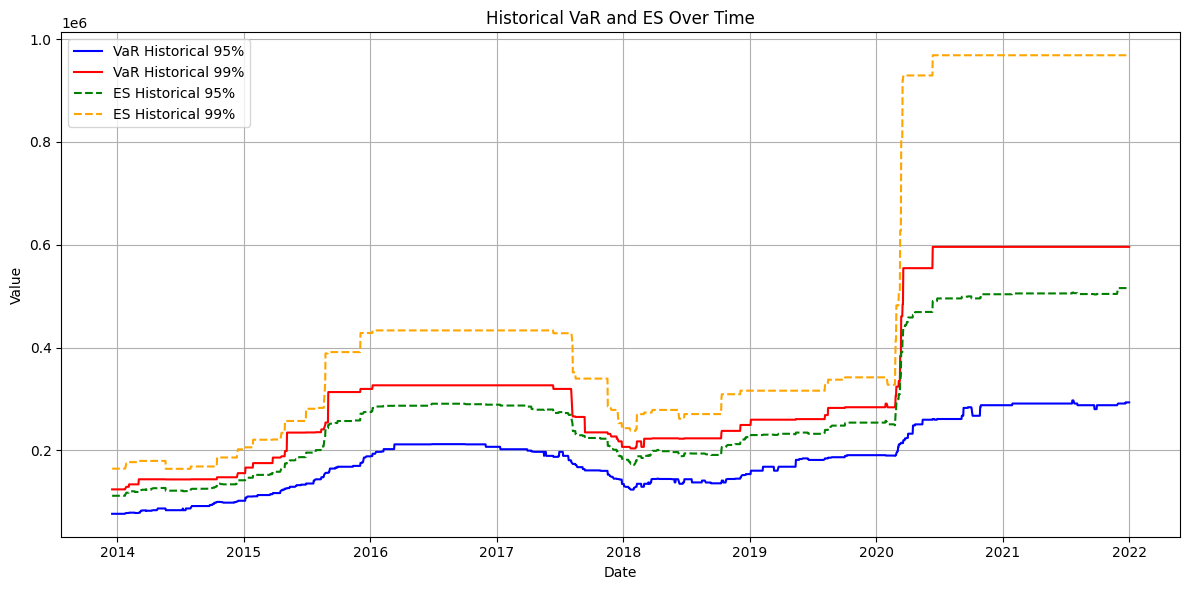

In [78]:
# Plot Historical VaR and ES over time
plt.figure(figsize=(12, 6))

# Extract the values for different confidence levels from the arrays
var_95 = [row[0] for row in var_results_df['VaR Historical']]
var_99 = [row[1] for row in var_results_df['VaR Historical']]
es_95 = [row[0] for row in es_results_df['ES Historical']]
es_99 = [row[1] for row in es_results_df['ES Historical']]

# Plot VaR Historical 95% and 99%
plt.plot(var_results_df['Date'], var_95, label='VaR Historical 95%', color='blue')
plt.plot(var_results_df['Date'], var_99, label='VaR Historical 99%', color='red')

# Plot ES Historical 95% and 99%
plt.plot(es_results_df['Date'], es_95, label='ES Historical 95%', color='green', linestyle='--')
plt.plot(es_results_df['Date'], es_99, label='ES Historical 99%', color='orange', linestyle='--')

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Historical VaR and ES Over Time')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

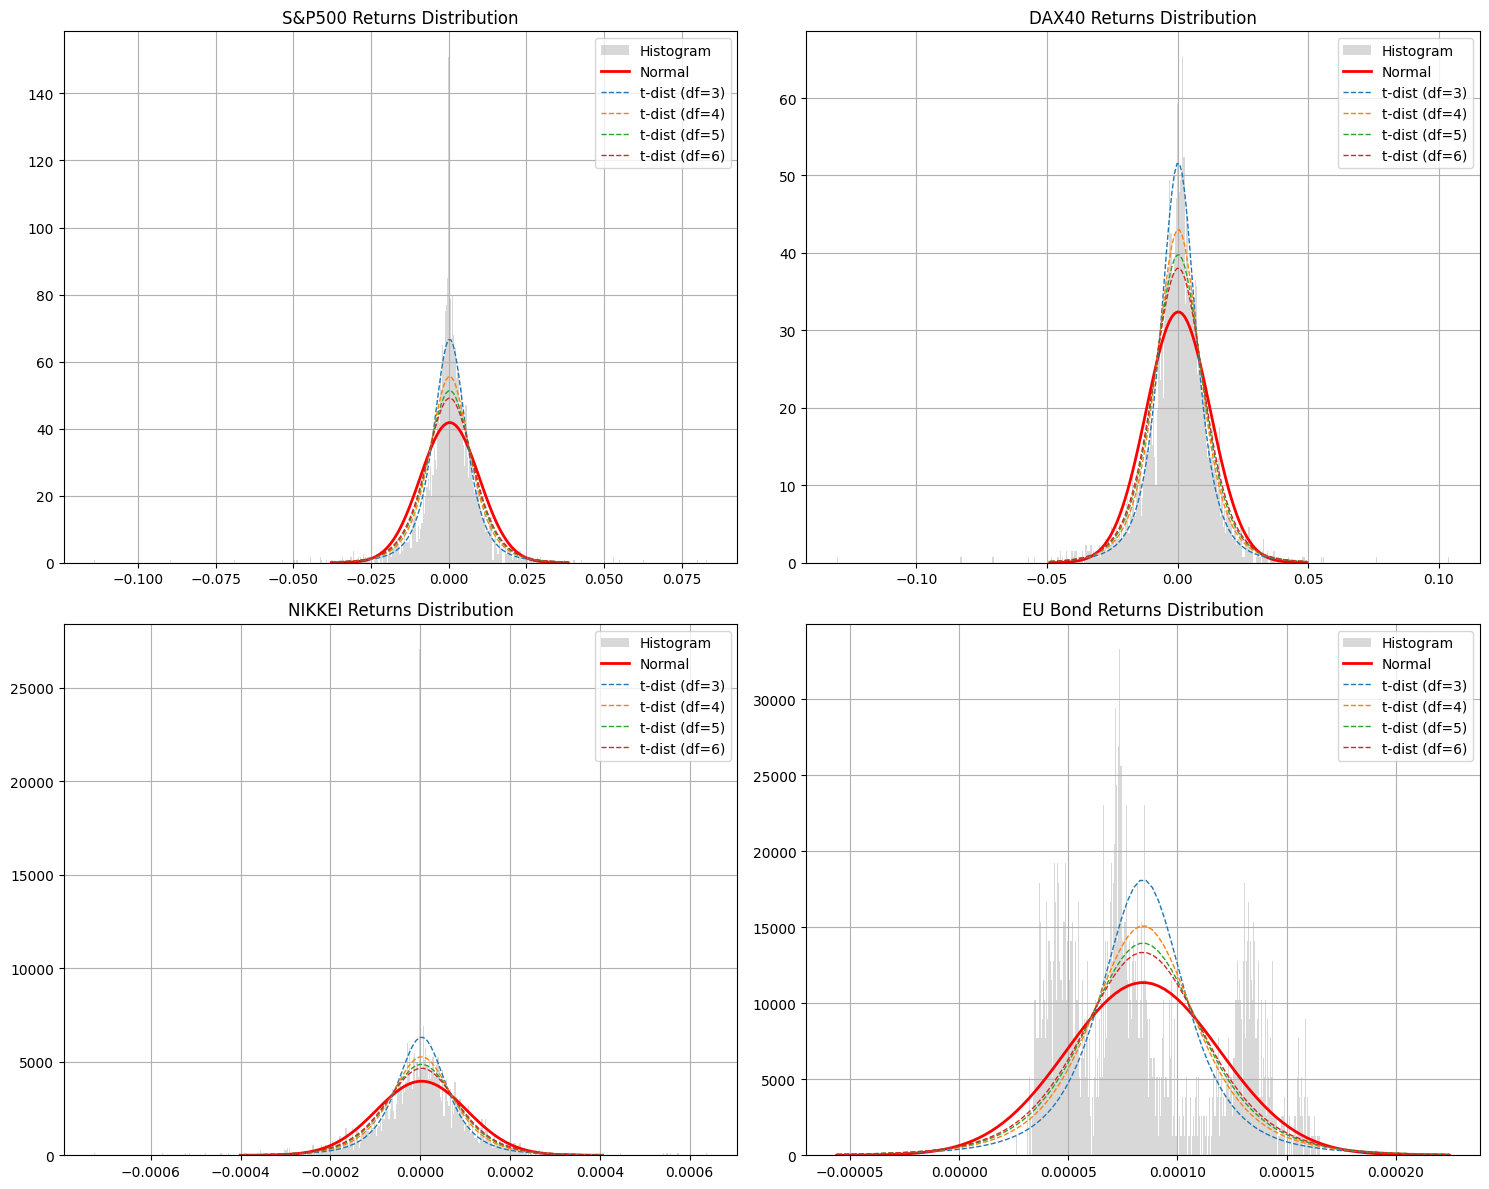

In [79]:
# Create subplots for all indices
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# S&P 500
sp500_returns = main_df['C_S&P500_Returns'].dropna()
mu_sp500 = sp500_returns.mean()
sigma_sp500 = sp500_returns.std()
x_sp500 = np.linspace(mu_sp500 - 4*sigma_sp500, mu_sp500 + 4*sigma_sp500, 100)
ax1.hist(sp500_returns, bins=500, density=True, alpha=0.3, color='grey', label='Histogram')
ax1.plot(x_sp500, st.norm.pdf(x_sp500, mu_sp500, sigma_sp500), 'r-', lw=2, label='Normal')
# Add t-distributions
for df in [3, 4, 5, 6]:
    s = sigma_sp500 / np.sqrt(df/(df-2))
    ax1.plot(x_sp500, st.t.pdf((x_sp500-mu_sp500)/s, df)/s, '--', lw=1, label=f't-dist (df={df})')
ax1.set_title('S&P500 Returns Distribution')
ax1.legend()
ax1.grid(True)

# DAX40
dax_returns = main_df['C_Dax40_Returns'].dropna()
mu_dax = dax_returns.mean()
sigma_dax = dax_returns.std()
x_dax = np.linspace(mu_dax - 4*sigma_dax, mu_dax + 4*sigma_dax, 100)
ax2.hist(dax_returns, bins=500, density=True, alpha=0.3, color='grey', label='Histogram')
ax2.plot(x_dax, st.norm.pdf(x_dax, mu_dax, sigma_dax), 'r-', lw=2, label='Normal')
# Add t-distributions
for df in [3, 4, 5, 6]:
    s = sigma_dax / np.sqrt(df/(df-2))
    ax2.plot(x_dax, st.t.pdf((x_dax-mu_dax)/s, df)/s, '--', lw=1, label=f't-dist (df={df})')
ax2.set_title('DAX40 Returns Distribution')
ax2.legend()
ax2.grid(True)

# NIKKEI
nikkei_returns = main_df['C_Nikkei_Returns'].dropna()
mu_nikkei = nikkei_returns.mean()
sigma_nikkei = nikkei_returns.std()
x_nikkei = np.linspace(mu_nikkei - 4*sigma_nikkei, mu_nikkei + 4*sigma_nikkei, 100)
ax3.hist(nikkei_returns, bins=500, density=True, alpha=0.3, color='grey', label='Histogram')
ax3.plot(x_nikkei, st.norm.pdf(x_nikkei, mu_nikkei, sigma_nikkei), 'r-', lw=2, label='Normal')
# Add t-distributions
for df in [3, 4, 5, 6]:
    s = sigma_nikkei / np.sqrt(df/(df-2))
    ax3.plot(x_nikkei, st.t.pdf((x_nikkei-mu_nikkei)/s, df)/s, '--', lw=1, label=f't-dist (df={df})')
ax3.set_title('NIKKEI Returns Distribution')
ax3.legend()
ax3.grid(True)

# EU Bond
bond_returns = main_df['Interest_Bond_daily_rate'].dropna()
mu_bond = bond_returns.mean()
sigma_bond = bond_returns.std()
x_bond = np.linspace(mu_bond - 4*sigma_bond, mu_bond + 4*sigma_bond, 100)
ax4.hist(bond_returns, bins=500, density=True, alpha=0.3, color='grey', label='Histogram')
ax4.plot(x_bond, st.norm.pdf(x_bond, mu_bond, sigma_bond), 'r-', lw=2, label='Normal')
# Add t-distributions
for df in [3, 4, 5, 6]:
    s = sigma_bond / np.sqrt(df/(df-2))
    ax4.plot(x_bond, st.t.pdf((x_bond-mu_bond)/s, df)/s, '--', lw=1, label=f't-dist (df={df})')
ax4.set_title('EU Bond Returns Distribution')
ax4.legend()
ax4.grid(True)

plt.tight_layout()
plt.show()

## GARCH(1,1) with constant conditional correlation 

## EWMA

In [80]:
import pandas as pd
import numpy as np
from typing import Dict, List, Union

def compute_ewma_volatility(
    returns: pd.DataFrame, 
    lambdas: List[float] = [0.94, 0.97]
) -> Dict[str, pd.DataFrame]:
    """
    Compute EWMA volatility for each risk factor using different lambda values.

    Parameters:
    ----------
    returns : pd.DataFrame
        DataFrame of returns (T x N), excluding Date column
    lambdas : List[float], optional
        List of smoothing factors, by default [0.94, 0.97]

    Returns:
    -------
    Dict[str, pd.DataFrame]
        Dictionary of DataFrames containing EWMA volatilities for each lambda
    """
    # Input validation
    if not isinstance(returns, pd.DataFrame):
        raise TypeError("returns must be a pandas DataFrame")
    
    # Remove Date column if present
    if 'Date' in returns.columns:
        returns = returns.drop('Date', axis=1)
    
    results = {}
    
    for lambda_ in lambdas:
        n_obs, n_assets = returns.shape
        ewma_vol = np.zeros((n_obs, n_assets))
        
        # Initialize first value with sample standard deviation
        ewma_vol[0] = returns.iloc[0].values.std()
        
        # Loop through time to apply EWMA formula
        for t in range(1, n_obs):
            ewma_vol[t] = np.sqrt(
                lambda_ * ewma_vol[t-1]**2 + 
                (1 - lambda_) * returns.iloc[t-1].values**2
            )
        
        # Store results in dictionary
        results[f'lambda_{lambda_}'] = pd.DataFrame(
            ewma_vol,
            index=returns.index,
            columns=returns.columns
        )
    
    return results

# Example usage
returns_df = main_df[['Date', 'C_S&P500_Returns', 'C_Dax40_Returns', 
                      'C_Nikkei_Returns', 'Interest_Bond_daily_rate']].dropna()
#set Date as index
returns_df.set_index('Date', inplace=True)
ewma_results = compute_ewma_volatility(returns_df)
print(ewma_results)

{'lambda_0.94':             C_S&P500_Returns  C_Dax40_Returns  C_Nikkei_Returns  \
Date                                                              
2012-01-05          0.001718         0.001718          0.001718   
2012-01-06          0.001759         0.001779          0.001666   
2012-01-09          0.001774         0.002309          0.001616   
2012-01-10          0.001774         0.002781          0.001566   
2012-01-11          0.002415         0.006453          0.001519   
...                      ...              ...               ...   
2022-12-23          0.013447         0.011335          0.000075   
2022-12-27          0.013107         0.011000          0.000075   
2022-12-28          0.012742         0.010707          0.000072   
2022-12-29          0.012665         0.010452          0.000070   
2022-12-30          0.012907         0.010451          0.000070   

            Interest_Bond_daily_rate  
Date                                  
2012-01-05                  0.0017

In [81]:
def filter_returns(returns: pd.DataFrame, ewma_vol: dict) -> dict:
    """
    Compute standardized (filtered) returns for each lambda value.

    Parameters:
    - returns: DataFrame of raw returns
    - ewma_vol: Dictionary containing DataFrames of EWMA volatilities for each lambda

    Returns:
    - filtered_returns: Dictionary of DataFrames with standardized returns for each lambda
    """
    filtered_returns = {}
    
    # Filter returns for each lambda value
    for lambda_key, vol_df in ewma_vol.items():
        filtered_returns[lambda_key] = returns / vol_df
    
    return filtered_returns

# Assuming returns_df and ewma_vol_df (from compute_ewma_volatility) are already defined
filtered_returns_dict = filter_returns(returns_df, ewma_results)

# Preview results for both lambda values
print("\nFiltered Returns (lambda = 0.94):")
print(filtered_returns_dict['lambda_0.94'].tail())
print("\nFiltered Returns (lambda = 0.97):")
print(filtered_returns_dict['lambda_0.97'].tail())



Filtered Returns (lambda = 0.94):
            C_S&P500_Returns  C_Dax40_Returns  C_Nikkei_Returns  \
Date                                                              
2022-12-23          0.409796         0.170141         -0.982271   
2022-12-27         -0.290931         0.352562          0.150246   
2022-12-28         -0.894266        -0.464965         -0.394053   
2022-12-29          1.281939         0.998662         -0.942262   
2022-12-30         -0.184111        -1.012553          0.003232   

            Interest_Bond_daily_rate  
Date                                  
2022-12-23                  1.093727  
2022-12-27                  1.097422  
2022-12-28                  1.096478  
2022-12-29                  1.091148  
2022-12-30                  1.092670  

Filtered Returns (lambda = 0.97):
            C_S&P500_Returns  C_Dax40_Returns  C_Nikkei_Returns  \
Date                                                              
2022-12-23          0.372714         0.166877        

In [82]:
def filtered_historical_simulation_multivariate(filtered_returns_dict: dict, ewma_vol_dict: dict,
                                              n_simulations: int = 10000, random_seed: int = None, 
                                              weights: np.ndarray = None) -> dict:
    """
    Perform Filtered Historical Simulation for a multi-asset portfolio for different lambda values.

    Parameters:
    - filtered_returns_dict: Dictionary of DataFrames of standardized residuals for each lambda
    - ewma_vol_dict: Dictionary of DataFrames of EWMA volatility for each lambda
    - n_simulations: number of simulated return vectors
    - random_seed: for reproducibility
    - weights: portfolio weights (numpy array of shape [n_assets])

    Returns:
    - Dictionary containing simulated portfolio returns for each lambda value
    """
    if random_seed is not None:
        np.random.seed(random_seed)
    
    results = {}
    
    # Process each lambda value
    for lambda_key in filtered_returns_dict.keys():
        filtered_returns = filtered_returns_dict[lambda_key]
        # print(filtered_returns)
        ewma_vol = ewma_vol_dict[lambda_key]
        
        assets = filtered_returns.columns
        print(f"Assets: {assets}")
        n_assets = len(assets)
        
        # Initialize simulated return matrix (n_simulations x n_assets)
        sim_returns = np.zeros((n_simulations, n_assets))

        for i, asset in enumerate(assets):
            if asset == 'Date':
                continue
            z_asset = filtered_returns[asset].dropna().values
            print(f"z_asset: {z_asset}")
            z_star = np.random.choice(z_asset, size=n_simulations, replace=True)
            print(f"z_star: {z_star}")
            sigma_t = ewma_vol[asset].iloc[-1]  # latest volatility for asset
            sim_returns[:, i] = sigma_t * z_star  # re-scale

        if weights is not None:
            portfolio_simulated_returns = sim_returns @ weights
            results[lambda_key] = pd.Series(portfolio_simulated_returns, 
                                          name=f"Simulated_Portfolio_Returns_{lambda_key}")
        else:
            results[lambda_key] = pd.DataFrame(sim_returns, columns=assets)

    return results

# Define weights in the same order as your DataFrame columns
weights = np.array([0.4, 0.3, 0.15, 0.15])  # Example: S&P500, DAX, Nikkei, Bond rate

# Run multivariate FHS simulation for both lambda values
simulated_returns = filtered_historical_simulation_multivariate(
    filtered_returns_dict,
    ewma_results,
    n_simulations=10000,
    random_seed=42,
    weights=weights
)

# Compute VaR and ES for 95% and 99% for each lambda value
confidence_levels = [0.95, 0.99]
results = {}

for lambda_key, sim_returns in simulated_returns.items():
    for cl in confidence_levels:
        alpha = 1 - cl
        percentile = alpha * 100
        var = -np.percentile(sim_returns, percentile)
        es = -sim_returns[sim_returns <= -var].mean()
        results[f"{lambda_key}_VaR_{int(cl * 100)}"] = var
        results[f"{lambda_key}_ES_{int(cl * 100)}"] = es

# Print results
for lambda_key in simulated_returns.keys():
    print(f"\nResults for {lambda_key}:")
    for cl in confidence_levels:
        print(f"Portfolio 1-day VaR ({int(cl * 100)}%): {results[f'{lambda_key}_VaR_{int(cl * 100)}']:.5f}")
        print(f"Portfolio 1-day ES  ({int(cl * 100)}%): {results[f'{lambda_key}_ES_{int(cl * 100)}']:.5f}")



Assets: Index(['C_S&P500_Returns', 'C_Dax40_Returns', 'C_Nikkei_Returns',
       'Interest_Bond_daily_rate'],
      dtype='object')
z_asset: [ 1.33787372 -1.13549314  0.99763746 ... -0.8942656   1.28193859
 -0.18411052]
z_star: [-0.37424382 -1.42907661 -1.4122883  ... -0.19876735  2.06650442
 -0.16672369]
z_asset: [-1.48357023 -3.52115645 -2.91913419 ... -0.46496539  0.99866185
 -1.01255345]
z_star: [ 0.53711372  0.86197465  1.42165999 ...  0.81970926  0.35231205
 -0.29390161]
z_asset: [-0.04935057 -0.07142184  0.         ... -0.39405252 -0.94226223
  0.00323218]
z_star: [-1.91759506  1.37546175  1.68655073 ... -1.54318117  0.44442142
  1.07739373]
z_asset: [0.09564512 0.09870365 0.1010405  ... 1.09647804 1.09114795 1.0926701 ]
z_star: [1.00393218 1.01057632 0.84811626 ... 0.96727998 1.17706123 0.90040646]
Assets: Index(['C_S&P500_Returns', 'C_Dax40_Returns', 'C_Nikkei_Returns',
       'Interest_Bond_daily_rate'],
      dtype='object')
z_asset: [ 1.33787372 -1.1485605   1.0130016  ... 

In [83]:
def filtered_historical_simulation_multiday(
    filtered_returns_dict: dict,
    ewma_vol_dict: dict,
    lambda_key: str,
    n_days: int = 1,
    n_simulations: int = 10000,
    random_seed: int = None,
    weights: np.ndarray = None
) -> pd.Series:
    """
    Simulate N-day portfolio returns using Filtered Historical Simulation.

    Returns:
    - Simulated N-day portfolio return series (n_simulations,)
    """
    if random_seed is not None:
        np.random.seed(random_seed)

    filtered_returns = filtered_returns_dict[lambda_key]
    ewma_vol = ewma_vol_dict[lambda_key]

    assets = filtered_returns.columns
    n_assets = len(assets)
    sim_returns = np.zeros((n_simulations, n_days, n_assets))

    for i, asset in enumerate(assets):
        z_asset = filtered_returns[asset].dropna().values
        sigma_t = ewma_vol[asset].iloc[-1]

        if len(z_asset) == 0 or np.isnan(sigma_t):
            raise ValueError(f"Cannot simulate for asset '{asset}': empty or invalid data.")

        for day in range(n_days):
            z_star = np.random.choice(z_asset, size=n_simulations, replace=True)
            sim_returns[:, day, i] = sigma_t * z_star

    # Combine all simulated daily returns into N-day portfolio PnL
    total_pnl = (sim_returns @ weights).sum(axis=1)

    return pd.Series(total_pnl, name=f"Simulated_{n_days}Day_Returns_{lambda_key}")


# Example usage with both lambda values
confidence_levels = [0.95, 0.99]
horizons = [1, 5, 10]
lambda_keys = ['lambda_0.94', 'lambda_0.97']

for lambda_key in lambda_keys:
    print(f"\n=== Results for {lambda_key} ===")
    for days in horizons:
        print(f"\n--- {days}-Day VaR & ES ---")
        sim_returns = filtered_historical_simulation_multiday(
            filtered_returns_dict,
            ewma_results,
            lambda_key,
            n_days=days,
            n_simulations=10000,
            random_seed=42,
            weights=weights
        )

        for cl in confidence_levels:
            alpha = 1 - cl
            percentile = alpha * 100
            var = -np.percentile(sim_returns, percentile)
            es = -sim_returns[sim_returns <= -var].mean()
            print(f"VaR ({int(cl*100)}%): {var:.5f} | ES ({int(cl*100)}%): {es:.5f}")



=== Results for lambda_0.94 ===

--- 1-Day VaR & ES ---
VaR (95%): 0.01033 | ES (95%): 0.01537
VaR (99%): 0.01861 | ES (99%): 0.02423

--- 5-Day VaR & ES ---
VaR (95%): 0.02305 | ES (95%): 0.03072
VaR (99%): 0.03513 | ES (99%): 0.04178

--- 10-Day VaR & ES ---
VaR (95%): 0.03160 | ES (95%): 0.04175
VaR (99%): 0.04755 | ES (99%): 0.05714

=== Results for lambda_0.97 ===

--- 1-Day VaR & ES ---
VaR (95%): 0.01102 | ES (95%): 0.01667
VaR (99%): 0.02021 | ES (99%): 0.02632

--- 5-Day VaR & ES ---
VaR (95%): 0.02477 | ES (95%): 0.03320
VaR (99%): 0.03858 | ES (99%): 0.04552

--- 10-Day VaR & ES ---
VaR (95%): 0.03371 | ES (95%): 0.04481
VaR (99%): 0.05075 | ES (99%): 0.06152


In [89]:
def rolling_fhs_multiday_var_es(
    returns_df: pd.DataFrame,
    weights: np.ndarray,
    window_size: int = 500,
    horizons: list = [1, 5, 10],
    confidence_levels: list = [0.95, 0.99],
    n_simulations: int = 1000,
    lambdas: list = [0.94, 0.97],
    random_seed: int = None
) -> tuple:
    """
    Rolling Filtered Historical Simulation for multi-day VaR & ES.
    """
    time_window = returns_df.loc['2012-01-05':'2021-12-31']

    var_results = []
    es_results = []

    for horizon in horizons:
        adjusted_window_size = int(window_size / horizon)

        for t in range(adjusted_window_size, len(time_window)):
            current_date = time_window.index[t]
            var_row = {'index': current_date}
            es_row = {'index': current_date}

            window = time_window.iloc[t - adjusted_window_size:t]


            try:
                # Compute EWMA vol
                ewma_results = compute_ewma_volatility(
                    window[['C_S&P500_Returns', 'C_Dax40_Returns', 'C_Nikkei_Returns', 'Interest_Bond_daily_rate']],
                    lambdas
                )
                # Filtered returns
                filtered_returns_dict = {}
                for lambda_key, vol_df in ewma_results.items():
                    safe_vol_df = vol_df.replace(0, np.nan).fillna(method='ffill')
                    filtered_returns = window[['C_S&P500_Returns', 'C_Dax40_Returns', 'C_Nikkei_Returns', 'Interest_Bond_daily_rate']] / safe_vol_df
                    filtered_returns_dict[lambda_key] = filtered_returns

                # Simulate for each lambda and confidence level
                for lambda_key in ewma_results.keys():
                    sim_returns = filtered_historical_simulation_multiday(
                        filtered_returns_dict,
                        ewma_results,
                        lambda_key,
                        n_days=horizon,
                        n_simulations=n_simulations,
                        weights=weights,
                        random_seed=random_seed
                    )

                    for cl in confidence_levels:
                        alpha = 1 - cl
                        var = np.percentile(sim_returns, 100 * alpha)
                        es = sim_returns[sim_returns <= var].mean()

                        var_key = f"VaR_{int(cl * 100)}_{lambda_key}_h{horizon}"
                        es_key = f"ES_{int(cl * 100)}_{lambda_key}_h{horizon}"

                        var_row[var_key] = var
                        es_row[es_key] = es

                    var_results.append(var_row)
                    es_results.append(es_row)

            except Exception as e:
                continue
    var_df = pd.DataFrame(var_results).set_index('index')
    es_df = pd.DataFrame(es_results).set_index('index')

    var_df.index.name = 'Date'
    es_df.index.name = 'Date'

    return var_df, es_df

In [90]:
import matplotlib.pyplot as plt

def plot_var_es_vs_actual_given_actuals(var_df, es_df, actual_returns_dict, lambdas, horizons, confidence_levels):
    """
    Plot VaR and ES against already computed actual portfolio returns.

    Parameters:
    - var_df: DataFrame of rolling VaR values
    - es_df: DataFrame of rolling ES values
    - actual_returns_dict: Dict of actual portfolio return Series keyed by horizon
    - lambdas: list of lambda values used (e.g. [0.94, 0.97])
    - horizons: list of horizon days (e.g. [1, 5, 10])
    - confidence_levels: list of confidence levels (e.g. [0.95, 0.99])
    """
    for h in horizons:
        actual_returns = actual_returns_dict[h].reindex(var_df.index)

        for lambda_ in lambdas:
            lambda_key = f"lambda_{lambda_}"

            for cl in confidence_levels:
                var_col = f"VaR_{int(cl * 100)}_{lambda_key}_h{h}"
                es_col = f"ES_{int(cl * 100)}_{lambda_key}_h{h}"

                plt.figure(figsize=(14, 5))
                plt.plot(actual_returns, label="Actual Portfolio Return", alpha=0.6)
                plt.plot(-var_df[var_col], label=f"VaR {int(cl * 100)}%", color='red', linestyle='--')
                plt.plot(-es_df[es_col], label=f"ES {int(cl * 100)}%", color='orange', linestyle=':')
                plt.title(f"{h}-Day VaR and ES vs Actual Returns | λ={lambda_} | CL={int(cl*100)}%")
                plt.axhline(0, color='gray', linestyle='-')
                plt.legend()
                plt.grid(True)
                plt.tight_layout()
                plt.show()


In [95]:
def compute_actual_portfolio_returns(returns_df, weights, horizons=[1, 5, 10]):
    actual_returns = {}
    weighted_returns = returns_df @ weights

    for h in horizons:
        actual_returns[h] = weighted_returns.rolling(window=h).sum().shift(-h + 1)
        actual_returns[h].name = f"Actual_{h}d"

    return actual_returns

actual_returns_dict = compute_actual_portfolio_returns(returns_df, weights)
returns_dfe = pd.DataFrame(actual_returns_dict)
display(returns_dfe)

1        5        10
Date                                  
2012-01-05  0.000167 0.005793 0.019343
2012-01-06 -0.002671 0.007674 0.023634
2012-01-09 -0.001290 0.007065 0.026003
2012-01-10  0.009980 0.012089 0.028968
2012-01-11 -0.000392 0.008660 0.017889
...              ...      ...      ...
2022-12-23  0.002795 0.001962      NaN
2022-12-27 -0.000337      NaN      NaN
2022-12-28 -0.006032      NaN      NaN
2022-12-29  0.009639      NaN      NaN
2022-12-30 -0.004102      NaN      NaN

[2804 rows x 3 columns]

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/885850428.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  safe_vol_df = vol_df.replace(0, np.nan).fillna(method='ffill')
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/885850428.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  safe_vol_df = vol_df.replace(0, np.nan).fillna(method='ffill')
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/885850428.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  safe_vol_df = vol_df.replace(0, np.nan).fillna(method='ffill')
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_75221/885850428.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will 

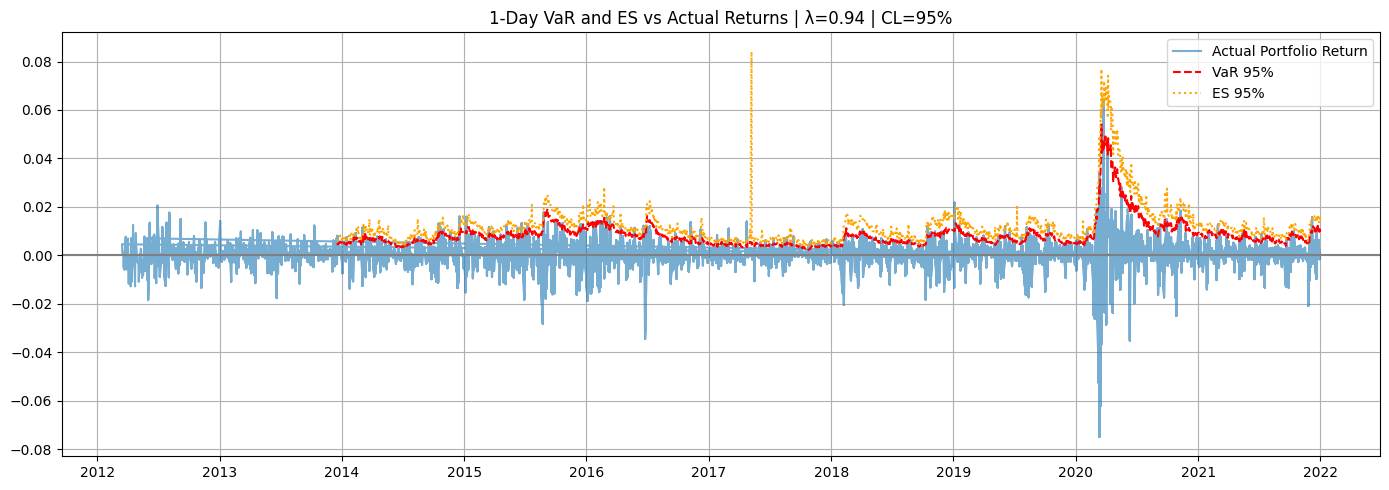

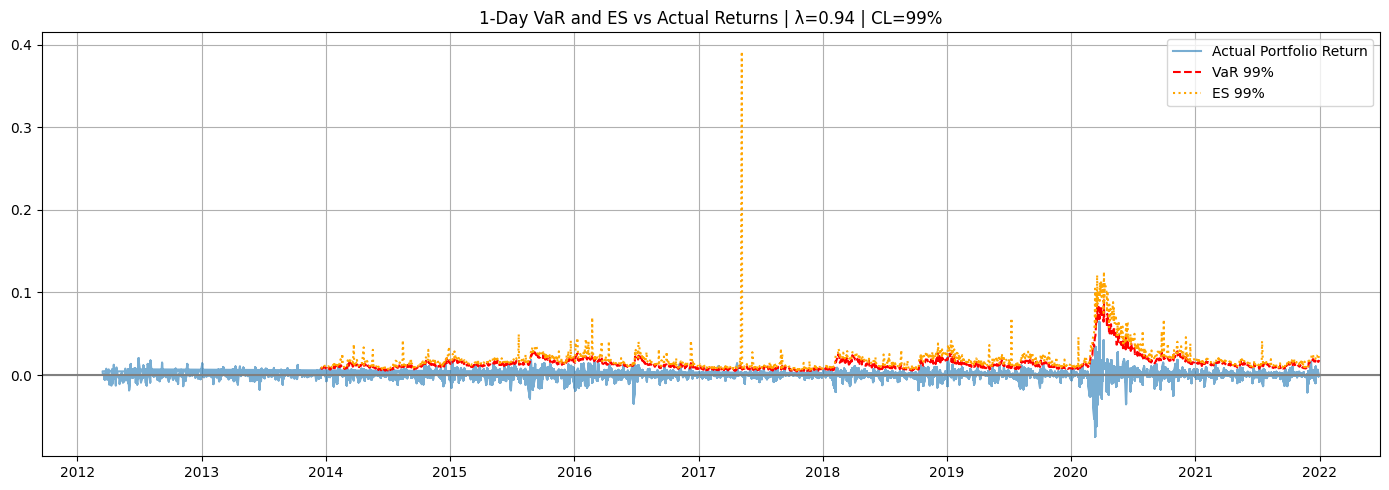

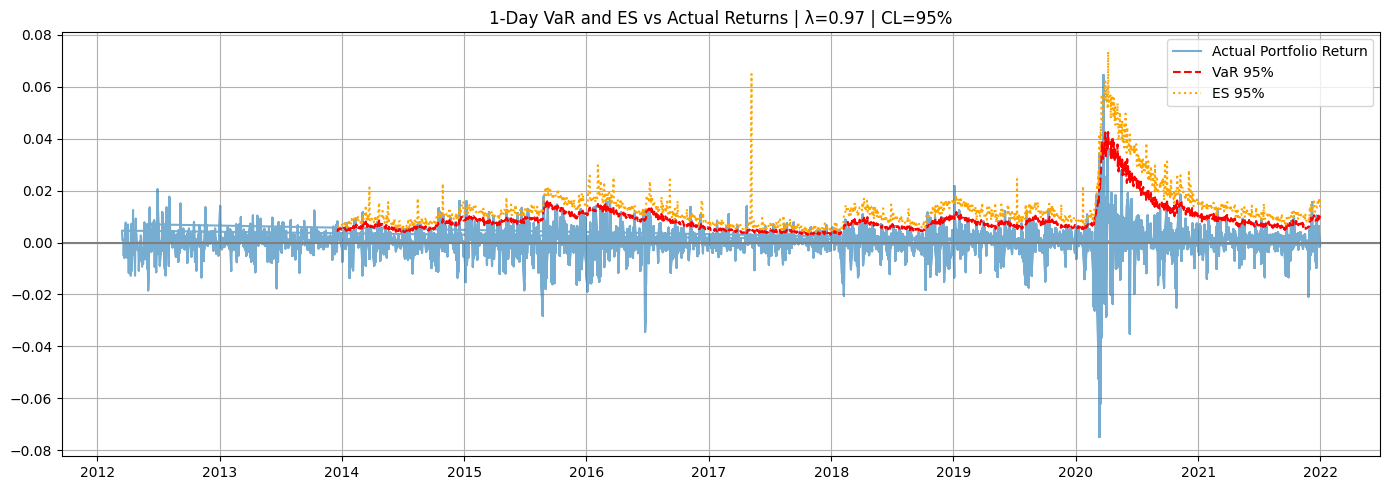

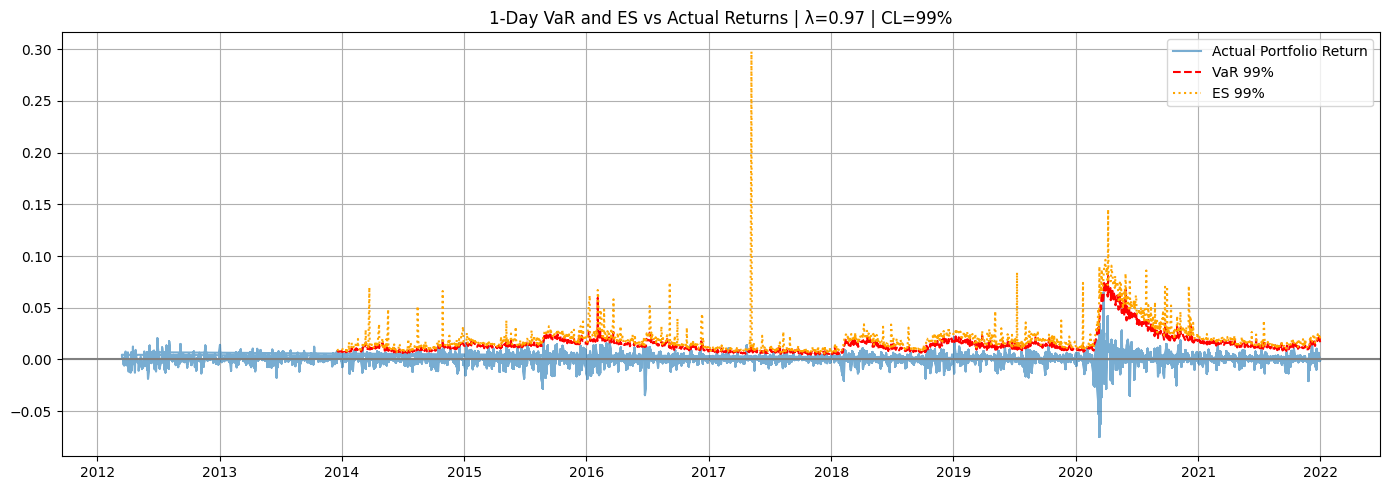

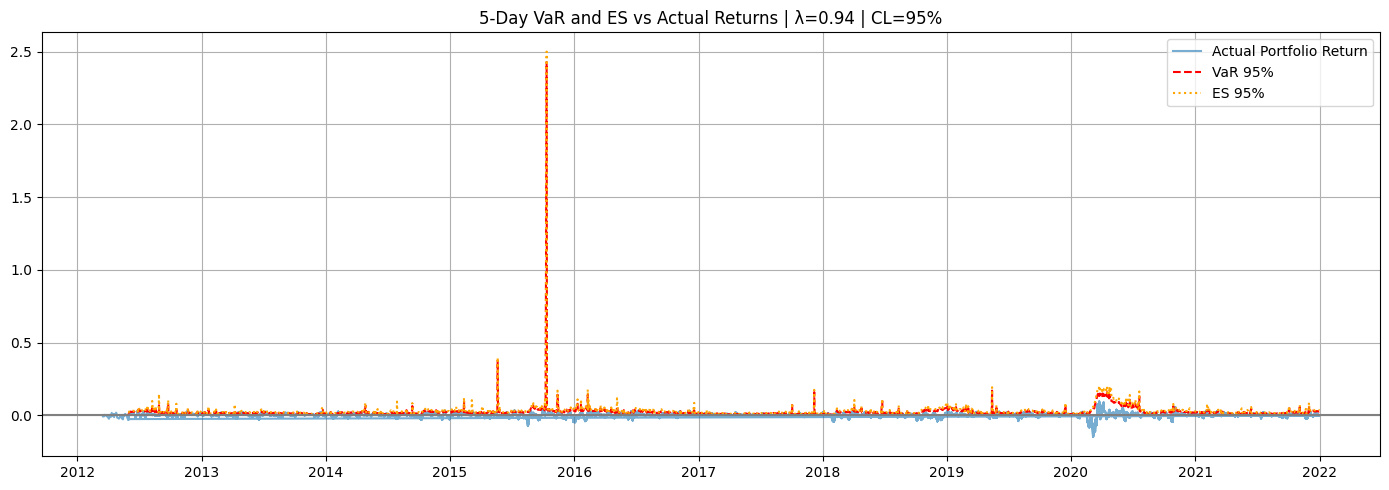

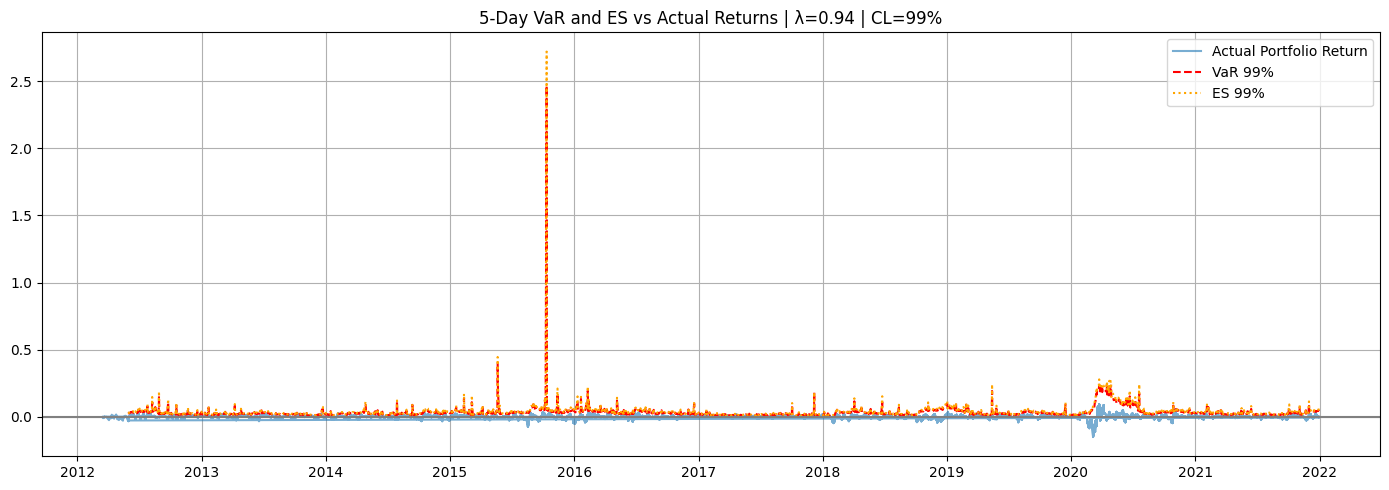

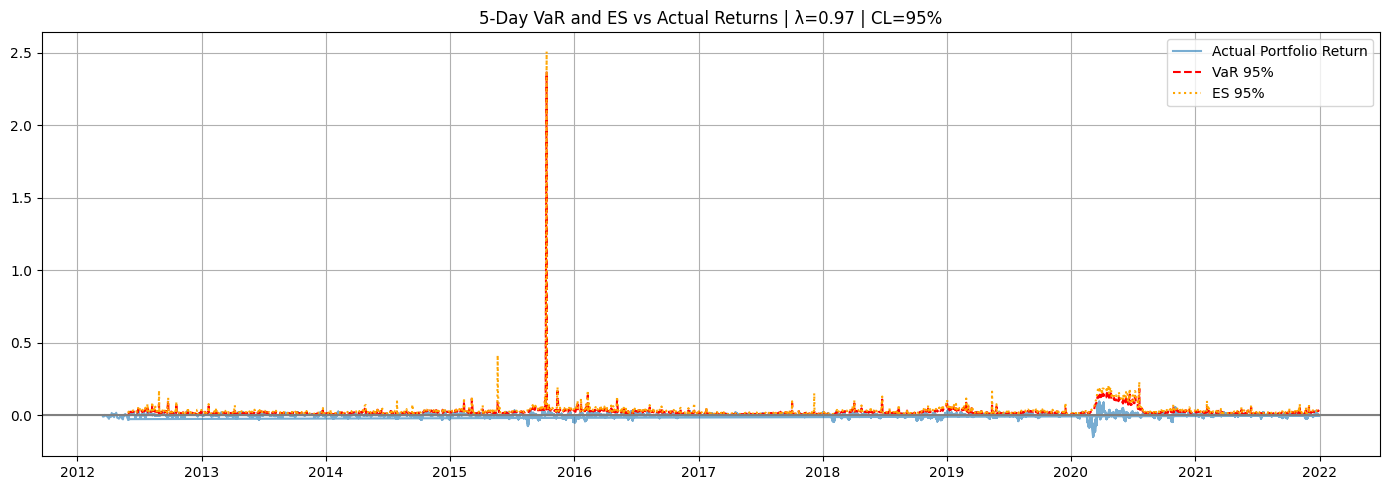

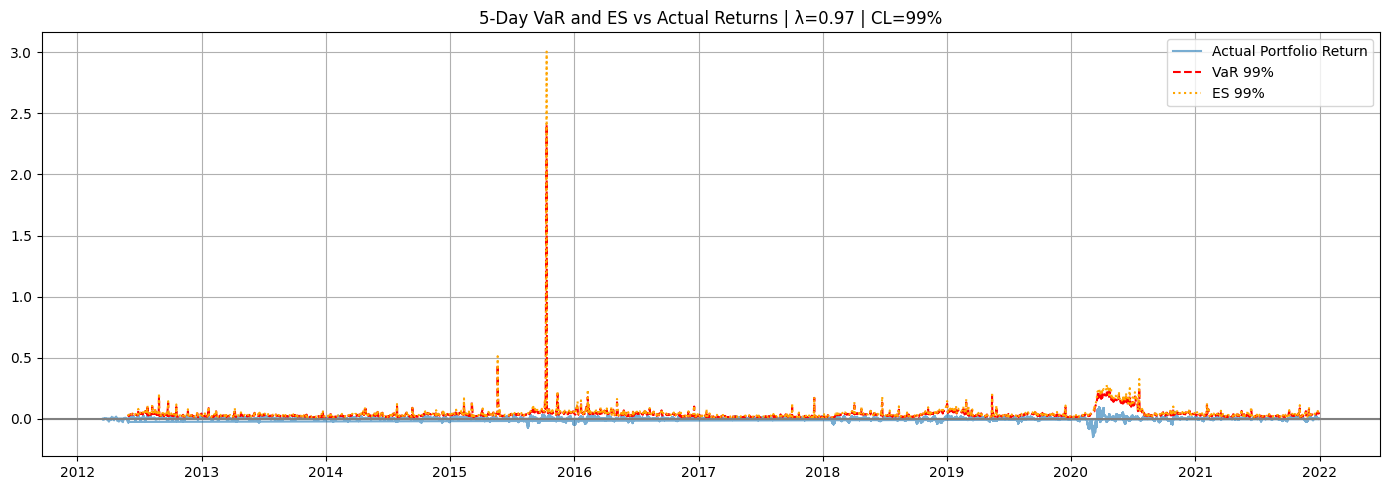

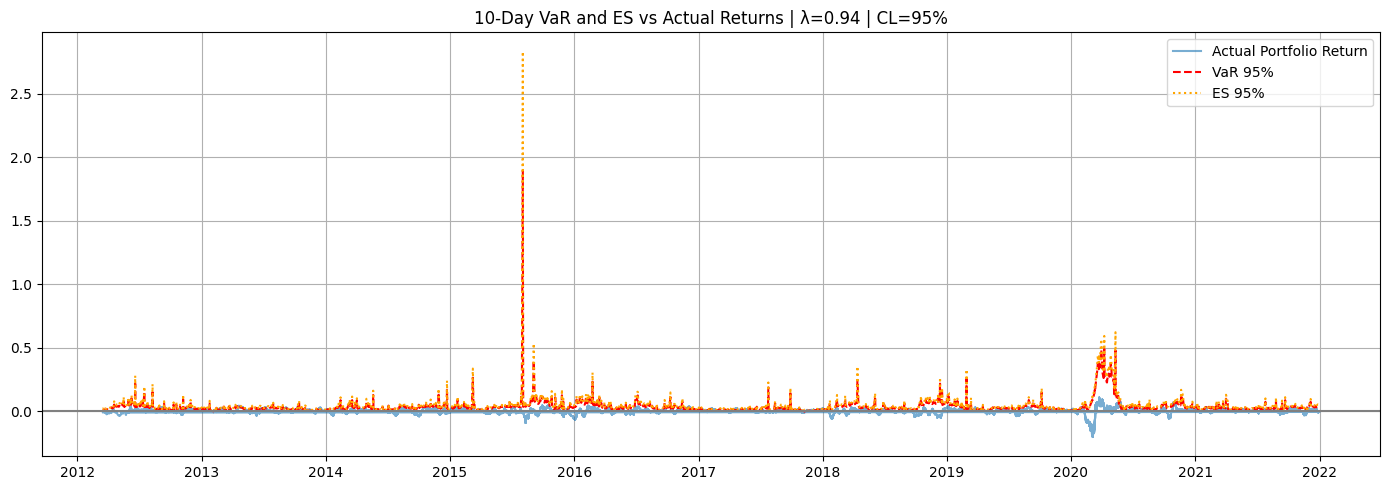

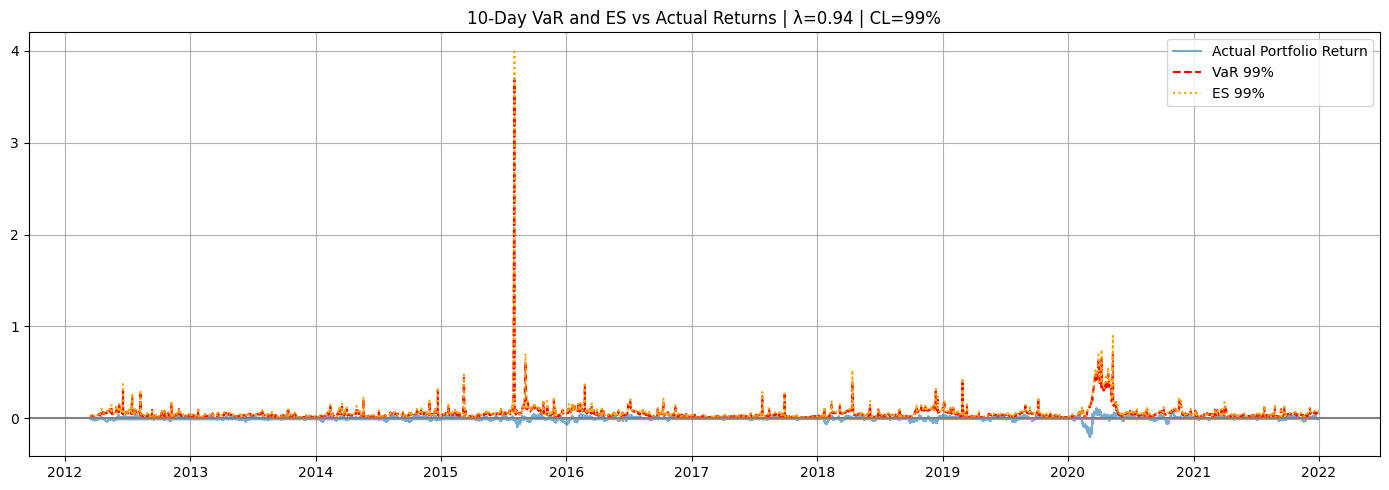

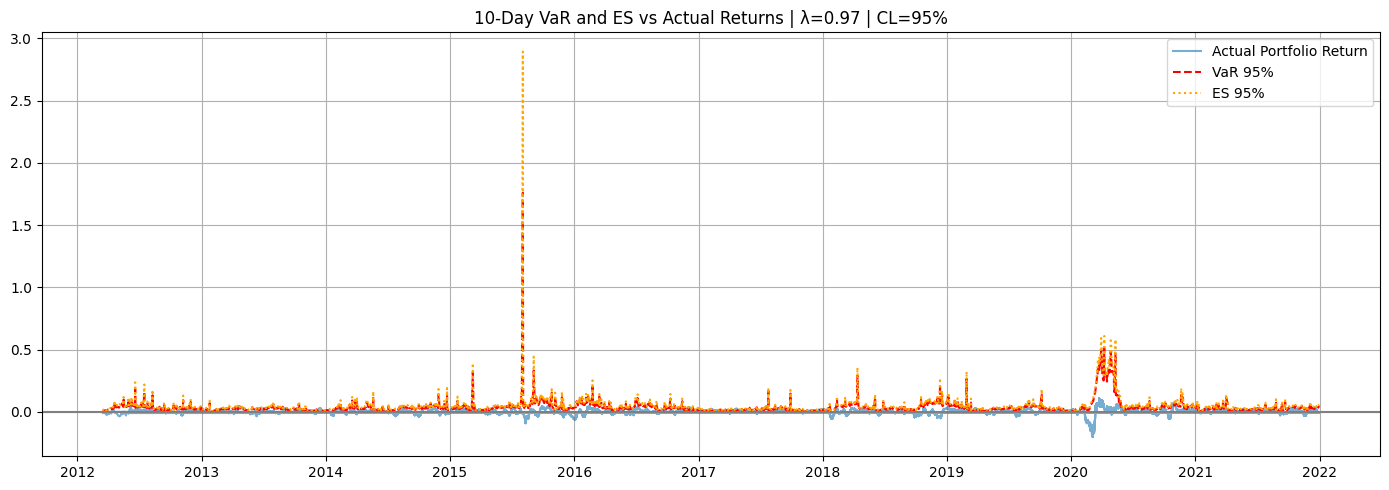

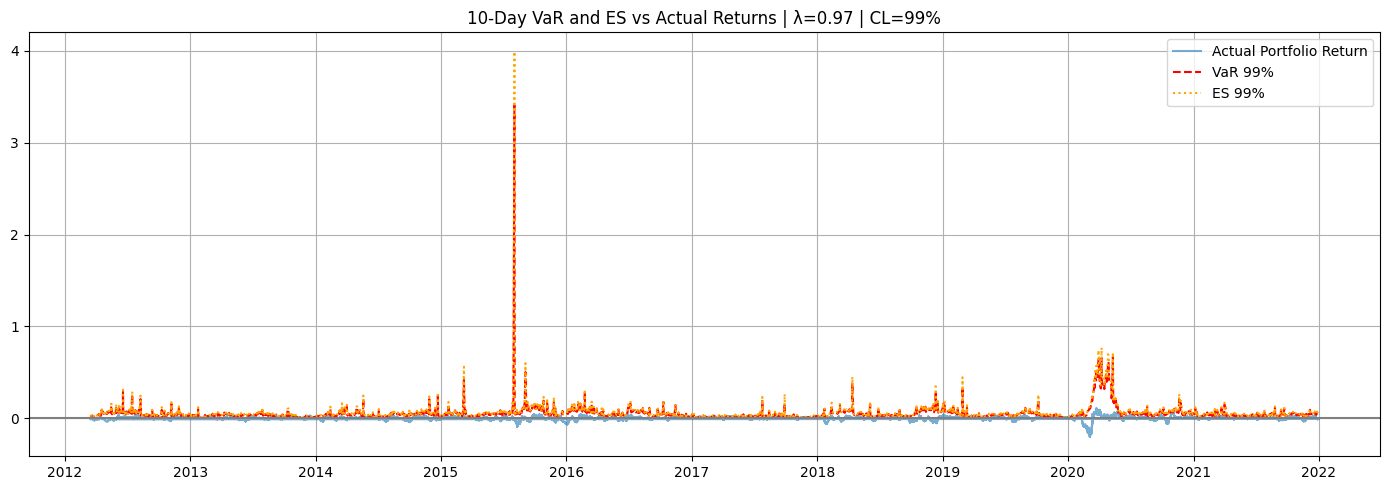

In [92]:
# Calculate VaR and ES using rolling FHS
var_df, es_df = rolling_fhs_multiday_var_es(
    returns_df=returns_df,  # DataFrame containing returns
    weights=weights,        # Portfolio weights
    window_size=500,       # Base window size
    horizons=[1, 5, 10],   # Horizons for VaR calculation
    confidence_levels=[0.95, 0.99],  # Confidence levels
    n_simulations=1000,    # Number of simulations
    lambdas=[0.94, 0.97]   # EWMA lambda values
)

# Plot the results
plot_var_es_vs_actual_given_actuals(
    var_df=var_df,
    es_df=es_df,
    actual_returns_dict=actual_returns_dict,
    lambdas=[0.94, 0.97],
    horizons=[1, 5, 10],
    confidence_levels=[0.95, 0.99]
)


In [114]:
#maximum likelihood estimation of GARCH(1,1) parameters
def garch_likelihood(params, returns):
    omega, alpha, beta = params
    T = len(returns)
    var = np.zeros(T)
    var[0] = omega / (1 - alpha - beta)
    ll = 0
    for t in range(2, T):
        var[t] = omega + alpha * returns[t-1]**2 + beta * var[t-1]
        ll += 0.5 * (np.log(2 * np.pi) + np.log(var[t]) + returns[t]**2 / var[t])
    return ll


In [122]:
# GARCH(1,1) parameter estimation using MLE
# This function estimates the parameters of a GARCH(1,1) model using maximum likelihood estimation (MLE).
def parameter_estimation_GARCH(returns):
    # Run the optimization
    result = minimize(
        garch_likelihood,
        x0=[0.00002, 0.05, 0.9],
        args=(returns,),
        method='SLSQP',
        bounds=[(1e-6, None), (0, 0.99), (0, 0.99)],
        constraints=[
            {'type': 'ineq', 'fun': lambda x: 0.999 - x[1] - x[2]}
        ],
        options={'disp': True}
    )

    # Return the optimization result
    return result

# # Check the optimization result
# if result.success:
#     print(f"Optimized parameters: omega={result.x[0]}, alpha={result.x[1]}, beta={result.x[2]}")
# else:
#     print("Optimization failed:", result.message)


In [129]:
# calculate the GARCH(1,1) volatility for returns t
def garch_volatility(returns):
    param = parameter_estimation_GARCH(returns)
    omega, alpha, beta = param.x
    T = len(returns)
    var = np.zeros(T)
    var[0]= param.x[0] / (1 - param.x[1] - param.x[2])
    for t in range(2, T):
        var[t] = omega + alpha * returns[t-1]**2 + beta * var[t-1]
    return np.sqrt(var)

In [130]:
# calculate correlation matrix of the 4 time series
# the method must take the returns as matrix of 4 vectors and return the correlation matrix
def correlation_matrix(returns):
    # Calculate the covariance matrix
    cov_matrix = np.cov(returns.T)
    
    # Calculate the standard deviations of each asset
    std_devs = np.sqrt(np.diag(cov_matrix))
    
    # Calculate the correlation matrix
    corr_matrix = cov_matrix / np.outer(std_devs, std_devs)
    
    return corr_matrix


In [131]:
# calculate the diagonal matrix with the garch volatility of the 4 time series
def diagonal_matrix(returns):
    # Initialize an empty dictionary to store volatilities for each column
    volatilities_dict = {}

    # Iterate through each column in the returns DataFrame
    for column in returns.columns:
        # Reset the index of the column to ensure numeric indexing
        column_returns = returns[column].dropna().reset_index(drop=True)
        
        # Calculate the GARCH(1,1) volatility for the column
        volatilities_dict[column] = garch_volatility(column_returns)
        
    # Combine the volatilities into a single array
    volatilities = np.array([vol[-1] for vol in volatilities_dict.values()])

    # Create a diagonal matrix with the volatilities
    #diag_matrix = np.diag(volatilities)
    
    return volatilities

In [132]:
# calculate the covariance matrix of the 4 time series
def covariance_matrix(returns):
    # Calculate the GARCH(1,1) volatilities
    volatilities = diagonal_matrix(returns)
    
    # Calculate the correlation matrix
    corr_matrix = correlation_matrix(returns)
    
    # Calculate the covariance matrix
    cov_matrix = np.outer(volatilities, volatilities) * corr_matrix
    
    return cov_matrix

In [133]:
# method to calculate the portfolio variance and volatility
def portfolio_variance(weights, cov_matrix):
    # Calculate the portfolio variance
    port_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    
    # Calculate the portfolio volatility
    port_volatility = np.sqrt(port_variance)
    
    return port_variance, port_volatility

In [134]:
# method to calculate the VaR and ES of the portfolio using the normal distribution
def portfolio_VaR_ES(weights, cov_matrix, alpha=0.95):
    # Calculate the portfolio variance and volatility
    _, port_volatility = portfolio_variance(weights, cov_matrix)
    
    # Calculate the VaR using the normal distribution
    VaR = -port_volatility * st.norm.ppf(1 - alpha)
    
    # Calculate the ES using the normal distribution
    ES = -port_volatility * (st.norm.pdf(st.norm.ppf(1 - alpha)) / (1 - alpha))
    
    return VaR, ES

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1761.2460558109442
            Iterations: 6
            Function evaluations: 9
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1557.7677839119842
            Iterations: 6
            Function evaluations: 9
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1666.566948092261
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1666.5550041095755
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1611.7170619439842
            Iterations: 5
            Function evaluations:

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1619.005066446726
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1528.3095971809153
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9087517673884
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.900205399997
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1808.3286007646595
            Iterations: 6
            Function evaluations: 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1589.8135509817612
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1449.0373861074447
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9154482315616
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9116286683575
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1715.4024788083534
            Iterations: 6
            Function evaluations

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.913797247201
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9127661854084
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1581.7421509298008
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1439.7367681030464
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9142007850442
            Iterations: 5
            Function evaluations:

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1700.271885023432
            Iterations: 6
            Function evaluations: 9
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1436.023828520389
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9141137592046
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9132686167898
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1744.0745519704178
            Iterations: 7
            Function evaluations: 

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1572.1895829444209
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1448.287863696389
            Iterations: 7
            Function evaluations: 15
            Gradient evaluations: 3
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9114363913682
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9142594277757
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1573.4435903722842
            Iterations: 5
            Function evaluations

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9115335663744
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.914449092687
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1572.534040667392
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1452.9315559996041
            Iterations: 8
            Function evaluations: 21
            Gradient evaluations: 4
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9117376563831
            Iterations: 5
            Function evaluations:

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1570.8390426500202
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1420.8789804265136
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9104402257801
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.916178207642
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1571.5751865817722
            Iterations: 5
            Function evaluations:

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1685.2528283515014
            Iterations: 6
            Function evaluations: 9
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1416.996270961252
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -2979.555556108765
            Iterations: 2
            Function evaluations: 8
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9164313767674
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1684.954345830854
            Iterations: 6
            Function evaluations: 9


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1681.67570699136
            Iterations: 6
            Function evaluations: 9
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1416.0806560190347
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9098118618679
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9169184759971
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1570.0076616599279
            Iterations: 5
            Function evaluations: 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1562.9062982401067
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1389.9528694453977
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9053487251554
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9184837395321
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1562.3075301369615
            Iterations: 5
            Function evaluations

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9043571377267
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9198472382295
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1559.5732398396985
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1389.5536873493795
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9042526999467
            Iterations: 5
            Function evaluations

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9033856320211
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9210399891442
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1561.7108579830194
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1397.5021722442586
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9044210471914
            Iterations: 5
            Function evaluations

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1564.921685390801
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1420.069513373328
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9048156922006
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9211793045818
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1566.1058855658248
            Iterations: 5
            Function evaluations: 

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1571.2380362652536
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1210.266462921007
            Iterations: 15
            Function evaluations: 61
            Gradient evaluations: 11
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9045239129316
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9212143682494
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1573.551271568648
            Iterations: 5
            Function evaluation

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1574.2354413938358
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1418.8630707655482
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9048382928813
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9211924661151
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1574.3654091266765
            Iterations: 5
            Function evaluations

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1690.3474809276065
            Iterations: 6
            Function evaluations: 9
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1419.8517110464022
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9046456306046
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9209524071662
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1575.7302940228883
            Iterations: 5
            Function evaluations

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1696.7707895533808
            Iterations: 7
            Function evaluations: 16
            Gradient evaluations: 3
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -619.397902571674
            Iterations: 7
            Function evaluations: 37
            Gradient evaluations: 6
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9002673296843
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9216342948184
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1577.5269642275375
            Iterations: 5
            Function evaluations:

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1579.4931501068102
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1471.971791394531
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9022782912946
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.921706992545
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1590.5341612701886
            Iterations: 5
            Function evaluations: 

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1857.9843401265684
            Iterations: 7
            Function evaluations: 14
            Gradient evaluations: 3
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1536.9680151001096
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.914426891413
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.922207261423
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1795.529262414523
            Iterations: 6
            Function evaluations: 

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1560.0328774017582
            Iterations: 6
            Function evaluations: 9
            Gradient evaluations: 2
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -717.1804413420641
            Iterations: 4
            Function evaluations: 27
            Gradient evaluations: 4
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -2979.4438850025
            Iterations: 2
            Function evaluations: 8
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9257327582898
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1486.4294195044824
            Iterations: 5
            Function evaluations: 4
 

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1473.4422823976208
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1465.1163868269105
            Iterations: 7
            Function evaluations: 16
            Gradient evaluations: 3
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9083164821232
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9262456336885
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1473.601459246105
            Iterations: 5
            Function evaluations

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1477.540314792002
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1412.5939990078302
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9096003961713
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9266489312554
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1475.9940608434563
            Iterations: 5
            Function evaluations:

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1542.976083785257
            Iterations: 6
            Function evaluations: 9
            Gradient evaluations: 2
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -637.2529189933174
            Iterations: 4
            Function evaluations: 27
            Gradient evaluations: 4
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.908927964849
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9270422111056
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1548.3558345632473
            Iterations: 6
            Function evaluations: 9

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1476.3151594888427
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1409.1378826798282
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.910422542483
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9271679611154
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1468.4975351865298
            Iterations: 5
            Function evaluations:

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1488.3194428327663
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1411.3775729550077
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9109932427773
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9272936603006
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1486.84473061515
            Iterations: 5
            Function evaluations: 

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9108234201603
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9274211322597
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1572.3095802209114
            Iterations: 7
            Function evaluations: 15
            Gradient evaluations: 3
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1414.7338295652132
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9107365238094
            Iterations: 5
            Function evaluation

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1617.7775839670896
            Iterations: 10
            Function evaluations: 30
            Gradient evaluations: 6
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -653.7923267212054
            Iterations: 8
            Function evaluations: 27
            Gradient evaluations: 4
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9096749946991
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9275411295555
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1488.7481445678527
            Iterations: 5
            Function

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9104366320105
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9276705922557
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1486.8969650004985
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1416.3285675919783
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9105100042086
            Iterations: 5
            Function evaluations

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9100953094141
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9277813864715
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1482.3974786875647
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1409.7521953165283
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9099616580143
            Iterations: 5
            Function evaluations

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:499: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_ieq = vstack([con

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1484.2008581471775
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1414.0160028037521
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9101033403924
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.927884323142
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1483.8304517278154
            Iterations: 5
            Function evaluations:

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1480.893185972051
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1410.6028254895687
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9101934278833
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9279603254897
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1551.5584334168777
            Iterations: 6
            Function evaluations:

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1472.1210470458834
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1407.1630480195363
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9100391748514
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9280119503092
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1599.5942513932525
            Iterations: 9
            Function evaluations

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1483.8348519515619
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1412.7739017210606
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9095494933426
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.928090236675
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1485.4942232420824
            Iterations: 5
            Function evaluations:

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1484.9763592107033
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1414.7614686919273
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9090188414903
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.928100476148
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1484.1343530974689
            Iterations: 5
            Function evaluations:

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:499: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_ieq = vstack([con['jac'](x, *con['args'])


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1485.10080658579
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1411.929353670662
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9093069198973
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.928104472223
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1558.8872937580309
            Iterations: 6
            Function evaluations: 9


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1485.271727404242
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -1443.6214009792686
            Iterations: 7
            Function evaluations: 15
            Gradient evaluations: 3
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9093566784547
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9280914611645
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1569.2032705549097
            Iterations: 7
            Function e

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1482.6494349986729
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1408.7007527392439
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9094122727086
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9281163899307
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1481.9429469335005
            Iterations: 5
            Function evaluations

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1477.8418041123998
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1409.270223575133
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.909111285786
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9281494063712
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1475.0642057381738
            Iterations: 5
            Function evaluations: 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:499: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_ieq = vstack([con['jac'](x, *con['args'])
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sq

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1573.3967570164016
            Iterations: 6
            Function evaluations: 9
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1419.1077952081246
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9093743824938
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9280985496664
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1494.4222841952353
            Iterations: 5
            Function evaluations

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1487.8742538925405
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1406.2220722035968
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9089131146204
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9280592972611
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1572.2227798867864
            Iterations: 6
            Function evaluations

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:499: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_ieq = vstack([con['jac'](x, *con['args'])
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sq

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1495.2932390622186
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1422.2719805167721
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.909289428889
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9279926048566
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1634.3207289204686
            Iterations: 8
            Function evaluations:

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1493.740823003061
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1418.9334780529725
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.908861333251
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9279662494398
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1493.3458981358915
            Iterations: 5
            Function evaluations: 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:499: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_ieq = vstack([con['jac'](x, *con['args'])
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sq

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1493.9071076756024
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1419.43737046362
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9088134664928
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9279298584836
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1493.8783250161546
            Iterations: 5
            Function evaluations: 

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1492.6972753248936
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1418.0586403303164
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9086057965744
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9279286512642
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1492.0369139447814
            Iterations: 5
            Function evaluations

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1490.9038189774244
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1413.6875799129919
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.908394733927
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9278980912034
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1490.282697491834
            Iterations: 5
            Function evaluations: 

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1568.768797901987
            Iterations: 7
            Function evaluations: 15
            Gradient evaluations: 3
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1408.1225205132484
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9076427534053
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.927940469427
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1482.1298501404349
            Iterations: 5
            Function evaluations:

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1610.7834535488369
            Iterations: 7
            Function evaluations: 16
            Gradient evaluations: 3
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1314.2381993265988
            Iterations: 7
            Function evaluations: 23
            Gradient evaluations: 3
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.8976776718173
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9276574474545
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1460.4189572002167
            Iterations: 5
            Function evaluatio

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:499: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_ieq = vstack([con['jac'](x, *con['args'])
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: V

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1516.6214480499455
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1255.355009789913
            Iterations: 12
            Function evaluations: 48
            Gradient evaluations: 8
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9122556729117
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9276122402484
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1588.3787569062983
            Iterations: 6
            Function evaluation

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1527.2502971235454
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1422.0225409771087
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9151485095076
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9273873919435
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1539.7899670649263
            Iterations: 5
            Function evaluations

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:499: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_ieq = vstack([con['jac'](x, *con['args'])
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: V

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1536.22398965098
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1442.4696274066048
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.914978881874
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9270535581159
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1537.7472812880187
            Iterations: 5
            Function evaluations: 4

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -962.3415229866795
            Iterations: 40
            Function evaluations: 182
            Gradient evaluations: 36
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9168651438076
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.924784605546
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1603.5001667368754
            Iterations: 6
            Function evaluations: 9
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1456.9116715353525
            Iterations: 5
            Function evaluatio

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:499: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_ieq = vstack([con['jac'](x, *con['args'])
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1622.8461647509903
            Iterations: 9
            Function evaluations: 26
            Gradient evaluations: 5
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1499.146794267752
            Iterations: 26
            Function evaluations: 136
            Gradient evaluations: 22
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.916699533122
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9239574248327
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1615.0002538402146
            Iterations: 7
            Function evaluati

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:499: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_ieq = vstack([con['jac'](x, *con['args'])
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1597.8691403150867
            Iterations: 7
            Function evaluations: 15
            Gradient evaluations: 3
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1506.6432176278106
            Iterations: 7
            Function evaluations: 23
            Gradient evaluations: 3
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9166446880888
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.9236354026712
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1515.8165387605632
            Iterations: 5
            Function evaluatio

/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/2206276040.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:499: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_ieq = vstack([con

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1505.11314982387
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1439.221350623091
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.916238457536
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1669.922717949776
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1499.0475940869335
            Iterations: 5
            Function evaluations: 4
 

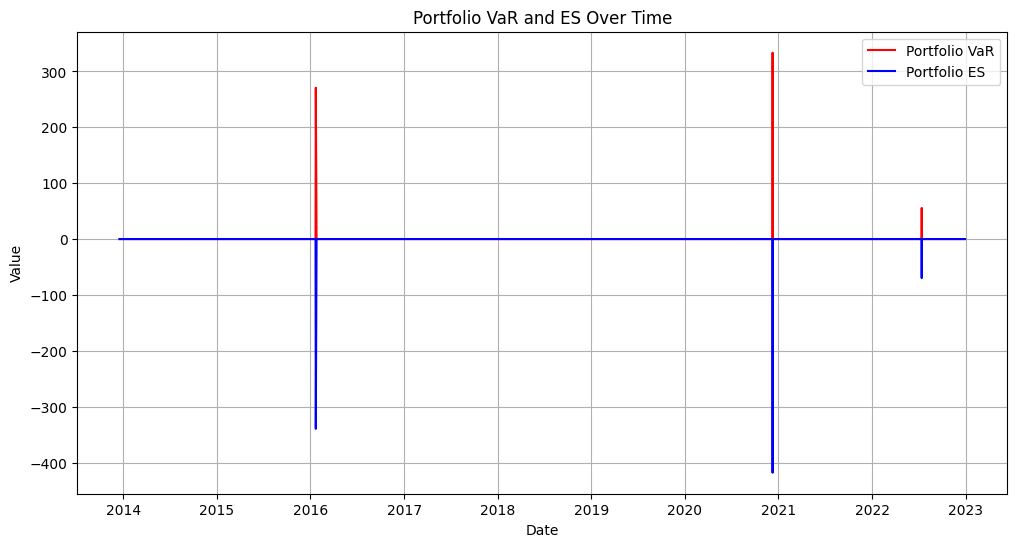

Date  Portfolio VaR  Portfolio ES
0    2013-12-17       0.011988     -0.015033
1    2013-12-18       0.016821     -0.021095
2    2013-12-19       0.014131     -0.017721
3    2013-12-20       0.016993     -0.021310
4    2013-12-23       0.014424     -0.018089
...         ...            ...           ...
2300 2022-12-23       0.014921     -0.018711
2301 2022-12-27       0.017900     -0.022447
2302 2022-12-28       0.014808     -0.018570
2303 2022-12-29       0.017526     -0.021979
2304 2022-12-30       0.017491     -0.021934

[2305 rows x 3 columns]

In [135]:
# main function to run the analysis
def main_analysis(time_window_size):
    # Initialize lists to store results
    portfolio_VaR_list = []
    portfolio_ES_list = []
    dates = []

    # Iterate through the dataset with a rolling time window
    for i in range(time_window_size, len(main_df)):
        # Extract the rolling time window
        window = main_df.iloc[i - time_window_size:i]
        current_date = main_df.iloc[i]['Date']
        
        # Calculate the returns for each asset in the window
        returns = window[['C_S&P500_Returns', 'C_Dax40_Returns', 'C_Nikkei_Returns', 'Interest_Bond_daily_rate']].dropna()

        # Define the weights for the portfolio
        weights = np.array([0.4, 0.3, 0.15, 0.15])

        # Calculate the covariance matrix
        cov_matrix = covariance_matrix(returns)

        # Calculate the portfolio VaR and ES
        VaR, ES = portfolio_VaR_ES(weights, cov_matrix)

        # Append results
        portfolio_VaR_list.append(VaR)
        portfolio_ES_list.append(ES)
        dates.append(current_date)

    # Create a DataFrame to store the results
    results_df = pd.DataFrame({
        'Date': dates,
        'Portfolio VaR': portfolio_VaR_list,
        'Portfolio ES': portfolio_ES_list
    })

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(results_df['Date'], results_df['Portfolio VaR'], label='Portfolio VaR', color='red')
    plt.plot(results_df['Date'], results_df['Portfolio ES'], label='Portfolio ES', color='blue')
    plt.title('Portfolio VaR and ES Over Time')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid()
    plt.show()

    return results_df

time_window_size = 500

main_analysis(time_window_size)

In [136]:
# show only the column names and the first 3 rows of the main dataframe
print(main_df.columns)
print(main_df.head(3))

Index(['Date', 'S&P500_Closing', 'Dax40_Closing', 'Nikkei_Closing',
       'U_S&P500_Returns', 'U_Dax40_Returns', 'U_Nikkei_Returns',
       'U_S&P500_Loss', 'U_Dax40_Loss', 'U_Nikkei_Loss', 'C_S&P500_Returns',
       'C_Dax40_Returns', 'C_Nikkei_Returns', 'C_S&P500_Loss', 'C_Dax40_Loss',
       'C_Nikkei_Loss', 'USD/EUR', 'JPY/EUR', 'TIME PERIOD',
       'Yield curve spot rate, 10-year maturity - Government bond',
       'Interest_Bond', 'Interest_Bond_Profit', 'Interest_Bond_Loss',
       'Interest_Bond_daily_rate', 'SP500_Investment', 'DAX40_Investment',
       'NIKKEI_Investment', 'EU_BOND_Investment', 'Portfolio_Value_EUR',
       'Portfolio_Change_EUR', 'Portfolio_loss'],
      dtype='object')
        Date  S&P500_Closing  Dax40_Closing  Nikkei_Closing  U_S&P500_Returns  \
0 2012-01-04     1277.300000    6111.550000     8560.110000               NaN   
1 2012-01-05     1281.060000    6095.990000     8488.710000          0.002939   
2 2012-01-06     1277.810000    6057.920000     

# Backtesting VaR and ES

In this section, we perform backtesting on the calculated Value at Risk (VaR) and Expected Shortfall (ES) measures. Backtesting helps assess the accuracy and reliability of the risk models.

We will:
1.  **Calculate Violations:** Identify the days where the actual portfolio loss exceeded the predicted VaR.
2.  **Compare Actual vs. Expected Violations (VaR):** Group violations by year and compare the observed number of violations against the number expected based on the confidence level (alpha).
3.  **Compare Actual Shortfall vs. Predicted ES (ES):** For the days a violation occurred, compare the average actual loss (shortfall) against the predicted ES, grouped by year.
4.  **Visualize Violations:** Plot the occurrences of violations over time to visually inspect for clustering or patterns.

In [142]:
def calculate_violations(actual_losses, var_predictions):
    """Checks for VaR violations."""
    return actual_losses > var_predictions

def backtest_var(violations, alpha, dates):
    """Compares actual vs. expected VaR violations yearly."""
    if not isinstance(violations, pd.Series):
        violations = pd.Series(violations, index=dates)
    elif violations.index.name != 'Date': # Ensure index is Date for grouping
         violations = violations.set_index(dates)
            
    violations_df = pd.DataFrame({'Violations': violations, 'Year': violations.index.year})
    yearly_violations = violations_df.groupby('Year')['Violations'].sum()
    yearly_counts = violations_df.groupby('Year')['Violations'].count()
    
    expected_violations = yearly_counts * (1 - alpha)
    
    summary = pd.DataFrame({
        'Actual Violations': yearly_violations,
        'Expected Violations': expected_violations,
        'Total Observations': yearly_counts
    })
    return summary

def backtest_es(actual_losses, violations, es_predictions, dates):
    """Compares actual average shortfall vs. predicted ES yearly."""
    # Ensure inputs are pandas Series with Date index
    if not isinstance(actual_losses, pd.Series):
        actual_losses = pd.Series(actual_losses, index=dates)
    elif actual_losses.index.name != 'Date':
        actual_losses = actual_losses.set_index(dates)
        
    if not isinstance(violations, pd.Series):
        violations = pd.Series(violations, index=dates)
    elif violations.index.name != 'Date':
        violations = violations.set_index(dates)
        
    if not isinstance(es_predictions, pd.Series):
        es_predictions = pd.Series(es_predictions, index=dates)
    elif es_predictions.index.name != 'Date':
        es_predictions = es_predictions.set_index(dates)

    results_df = pd.DataFrame({
        'Actual_Loss': actual_losses,
        'Violation': violations,
        'Predicted_ES': es_predictions,
        'Year': actual_losses.index.year
    })
    
    # Filter for violations
    violation_data = results_df[results_df['Violation']]
    
    # Calculate yearly averages
    yearly_avg_actual_shortfall = violation_data.groupby('Year')['Actual_Loss'].mean()
    yearly_avg_predicted_es = violation_data.groupby('Year')['Predicted_ES'].mean()
    yearly_violation_count = violation_data.groupby('Year').size()

    summary = pd.DataFrame({
        'Avg Actual Shortfall': yearly_avg_actual_shortfall,
        'Avg Predicted ES': yearly_avg_predicted_es,
        'Violation Count': yearly_violation_count
    })
    return summary

def plot_violations(violations, dates, title):
    """Plots VaR violations over time."""
    plt.figure(figsize=(15, 4))
    plt.plot(dates, violations, 'ro', markersize=4, alpha=0.7, label='Violation')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Violation (1=Yes, 0=No)')
    plt.yticks([0, 1])
    plt.grid(axis='y', linestyle='--')
    plt.show()

def run_backtesting(main_df, var_results_df, es_results_df):
    """Runs the backtesting process for VaR and ES models."""
    # Align main_df with var/es results (which start after the initial window)
    backtest_dates = var_results_df['Date']
    backtest_data = main_df[main_df['Date'].isin(backtest_dates)].set_index('Date')
    actual_losses = backtest_data['Portfolio_loss']

    # Confidence levels used
    alphas = [0.95, 0.99]
    alpha_indices = {0.95: 0, 0.99: 1} # Index mapping for results arrays

    # Iterate through models (columns in var_results_df/es_results_df)
    var_model_cols = [col for col in var_results_df.columns if col != 'Date']
    es_model_cols = [col for col in es_results_df.columns if col != 'Date']

    for i, model_name in enumerate(var_model_cols):
        print(f"\n--- Backtesting for Model: {model_name} ---")
        
        # Extract predictions for this model
        # Need to handle the fact that predictions are stored as arrays [pred_95, pred_99]
        var_preds_list = var_results_df[model_name].tolist()
        # Ensure alignment between var and es model columns
        if i < len(es_model_cols):
            es_preds_list = es_results_df[es_model_cols[i]].tolist()
        else:
            print(f"  Warning: No matching ES column found for {model_name}. Skipping ES backtest.")
            es_preds_list = None
        
        for alpha in alphas:
            alpha_idx = alpha_indices[alpha]
            print(f"\nConfidence Level: {alpha*100}%")
            
            # Extract predictions for the specific alpha
            # Handle potential errors if data isn't as expected (e.g., not a list/array)
            try:
                var_predictions = pd.Series([p[alpha_idx] for p in var_preds_list], index=backtest_dates)
                if es_preds_list:
                    es_predictions = pd.Series([p[alpha_idx] for p in es_preds_list], index=backtest_dates)
                else:
                    es_predictions = None
            except (TypeError, IndexError) as e:
                print(f"  Error extracting predictions for alpha={alpha}: {e}. Skipping.")
                continue
                
            # 1. Calculate Violations
            violations = calculate_violations(actual_losses, var_predictions)
            
            # 2. Backtest VaR
            var_summary = backtest_var(violations, alpha, backtest_dates)
            print("\nVaR Backtest Summary (Yearly):")
            display(var_summary)
            
            # 3. Backtest ES
            if es_predictions is not None:
                es_summary = backtest_es(actual_losses, violations, es_predictions, backtest_dates)
                print("\nES Backtest Summary (Yearly):")
                display(es_summary)
            
            # 4. Plot Violations
            plot_violations(violations, backtest_dates, f'VaR Violations for {model_name} (alpha={alpha})')

In [144]:
# Call the backtesting function with the required dataframes
run_backtesting(main_df, var_results_df, es_results_df)

KeyError: 'Date'

### Backtesting Interpretation

Review the tables and plots above:

*   **VaR Backtest:** Compare 'Actual Violations' to 'Expected Violations' each year. Significant deviations might indicate issues with the VaR model's calibration. If actual violations consistently exceed expected, the model underestimates risk. If they are consistently lower, it might be too conservative.
*   **ES Backtest:** Compare 'Avg Actual Shortfall' to 'Avg Predicted ES'. If the actual average shortfall during violations is consistently higher than the predicted ES, the model underestimates the severity of tail losses.
*   **Violation Plots:** Look for patterns. Ideally, violations should be randomly distributed. Clustering of violations suggests the model fails to adapt quickly to changing market volatility (violation dependence).


Start Date   End Date  Mean S&P500 Returns
0 2012-01-04 2013-12-17             0.000543
1 2012-01-05 2013-12-18             0.000566
2 2012-01-06 2013-12-19             0.000560
3 2012-01-09 2013-12-20             0.000571
4 2012-01-10 2013-12-23             0.000575

Start Date   End Date  Mean DAX40 Returns
0 2012-01-04 2013-12-17            0.000793
1 2012-01-05 2013-12-18            0.000812
2 2012-01-06 2013-12-19            0.000851
3 2012-01-09 2013-12-20            0.000877
4 2012-01-10 2013-12-23            0.000909

Start Date   End Date  Mean Nikkei Returns
0 2012-01-04 2013-12-17             0.000010
1 2012-01-05 2013-12-18             0.000010
2 2012-01-06 2013-12-19             0.000011
3 2012-01-09 2013-12-20             0.000011
4 2012-01-10 2013-12-23             0.000011

Start Date   End Date  Mean EU Bond Returns
0 2012-01-04 2013-12-17              0.000137
1 2012-01-05 2013-12-18              0.000137
2 2012-01-06 2013-12-19              0.000137
3 2012-01-09 2013-12-20              0.000137
4 2012-01-10 2013-12-23              0.000137

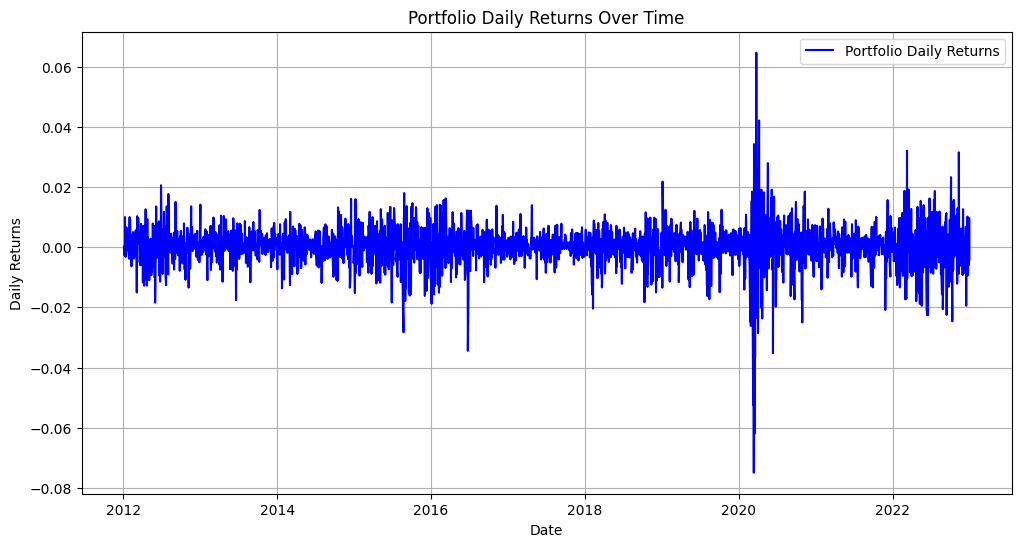

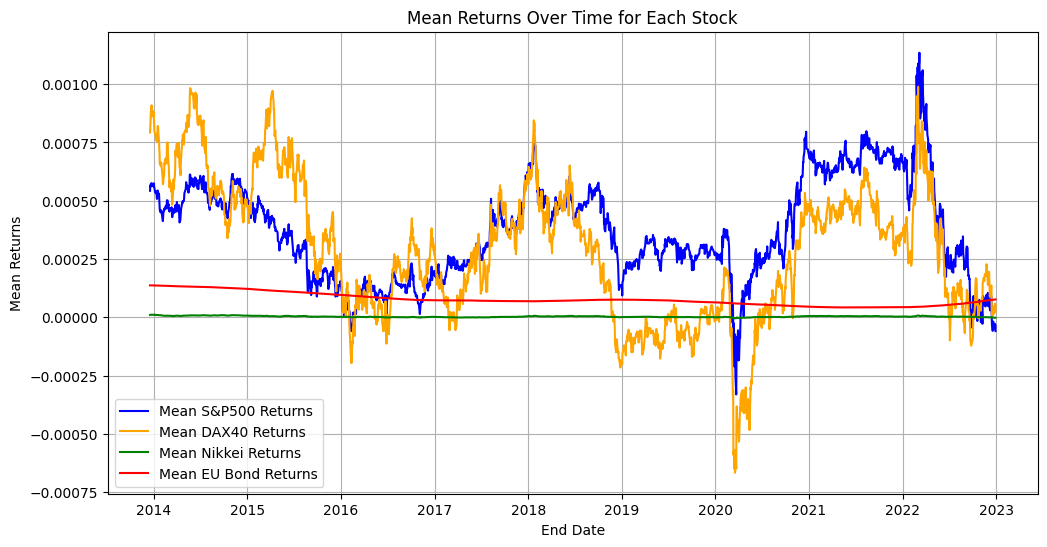

In [145]:
# checking assumption on taking mean = 0 
# Calculate portfolio daily returns
main_df['Portfolio_Daily_Returns'] = (
    weights['S&P500'] * main_df['C_S&P500_Returns'] +
    weights['DAX40'] * main_df['C_Dax40_Returns'] +
    weights['NIKKEI'] * main_df['C_Nikkei_Returns'] +
    weights['EU-BOND'] * main_df['Interest_Bond_daily_rate']
)

# make a graph of the portfolio daily returns
plt.figure(figsize=(12, 6))
plt.plot(main_df['Date'], main_df['Portfolio_Daily_Returns'], label='Portfolio Daily Returns', color='blue')
plt.title('Portfolio Daily Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Daily Returns')
plt.legend()
plt.grid()
#plt.show()

# Calculate the mean of the returns for each stock over a subset of the data defined on the time range
# Define the sample size
sample_size = 500

# Initialize variables to store the mean returns for each stock for each time window
mean_sp500_returns_list = []
mean_dax40_returns_list = []
mean_nikkei_returns_list = []
mean_eu_bond_returns_list = []

# Loop through the data with a fixed sample size
for i in range(sample_size, len(main_df)):
    time_range_start = main_df['Date'].iloc[i - sample_size]
    time_range_end = main_df['Date'].iloc[i]
    time_range_df = main_df[(main_df['Date'] >= time_range_start) & (main_df['Date'] <= time_range_end)]
    
    # Calculate mean returns for each stock
    mean_sp500_returns = time_range_df['C_S&P500_Returns'].mean()
    mean_dax40_returns = time_range_df['C_Dax40_Returns'].mean()
    mean_nikkei_returns = time_range_df['C_Nikkei_Returns'].mean()
    mean_eu_bond_returns = time_range_df['Interest_Bond_daily_rate'].mean()
    
    # Append the results to the respective lists
    mean_sp500_returns_list.append({
        'Start Date': time_range_start,
        'End Date': time_range_end,
        'Mean S&P500 Returns': mean_sp500_returns
    })
    mean_dax40_returns_list.append({
        'Start Date': time_range_start,
        'End Date': time_range_end,
        'Mean DAX40 Returns': mean_dax40_returns
    })
    mean_nikkei_returns_list.append({
        'Start Date': time_range_start,
        'End Date': time_range_end,
        'Mean Nikkei Returns': mean_nikkei_returns
    })
    mean_eu_bond_returns_list.append({
        'Start Date': time_range_start,
        'End Date': time_range_end,
        'Mean EU Bond Returns': mean_eu_bond_returns
    })

# Convert the results to DataFrames for easier analysis
mean_sp500_returns_df = pd.DataFrame(mean_sp500_returns_list)
mean_dax40_returns_df = pd.DataFrame(mean_dax40_returns_list)
mean_nikkei_returns_df = pd.DataFrame(mean_nikkei_returns_list)
mean_eu_bond_returns_df = pd.DataFrame(mean_eu_bond_returns_list)

# Display the results
display(mean_sp500_returns_df.head())
display(mean_dax40_returns_df.head())
display(mean_nikkei_returns_df.head())
display(mean_eu_bond_returns_df.head())

# Plot the mean returns for each stock over time
plt.figure(figsize=(12, 6))
plt.plot(mean_sp500_returns_df['End Date'], mean_sp500_returns_df['Mean S&P500 Returns'], label='Mean S&P500 Returns', color='blue')
plt.plot(mean_dax40_returns_df['End Date'], mean_dax40_returns_df['Mean DAX40 Returns'], label='Mean DAX40 Returns', color='orange')
plt.plot(mean_nikkei_returns_df['End Date'], mean_nikkei_returns_df['Mean Nikkei Returns'], label='Mean Nikkei Returns', color='green')
plt.plot(mean_eu_bond_returns_df['End Date'], mean_eu_bond_returns_df['Mean EU Bond Returns'], label='Mean EU Bond Returns', color='red')
plt.title('Mean Returns Over Time for Each Stock')
plt.xlabel('End Date')
plt.ylabel('Mean Returns')
plt.legend()
plt.grid()
plt.show()